## Import Libraries

In [1]:
'''basics'''
import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join('..', 'src')))
sys.setrecursionlimit(20500)
import pandas as pd
import pickle5 as pickle
import numpy as np

'''Plotting'''
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

'''features'''
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import label_binarize

'''Classifiers'''
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB


'''Metrics/Evaluation'''
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from scipy import interp
from itertools import cycle
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn_hierarchical_classification.classifier import HierarchicalClassifier
from sklearn_hierarchical_classification.constants import ROOT
from sklearn_hierarchical_classification.metrics import h_fbeta_score, multi_labeled
from sklearn.pipeline import Pipeline


import warnings
warnings.filterwarnings('ignore')


# Enabling

## Import data and holdout data for prediction

In [2]:
df = pd.read_excel('../data/processed/encoded_labels/enabling.xlsx')
df.columns

Index(['Unnamed: 0', 'PIMS_ID', 'all_text_clean', 'all_text_clean_spacy',
       'enabling', 'mainstream', 'alignment', 'advocacy_towards_policy_makers',
       'public_campaign', 'community_engagement'],
      dtype='object')

In [3]:
df_labels = df.drop(['Unnamed: 0', 'PIMS_ID', 'all_text_clean', 'all_text_clean_spacy', 'enabling'], axis=1)
counts = []
categories = list(df_labels.columns.values)
for i in categories:
    counts.append((i, df_labels[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_inputs'])
df_stats

,category,number_of_inputs
0,mainstream,69
1,alignment,13
2,advocacy_towards_policy_makers,14
3,public_campaign,7
4,community_engagement,32


Text(0.5, 0, 'category')

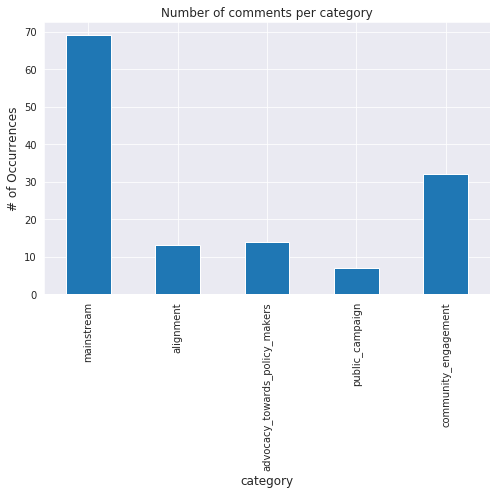

In [4]:
df_stats.plot(x='category', y='number_of_inputs', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

## How many comments have multi labels

Text(0.5, 0, '# of categories')

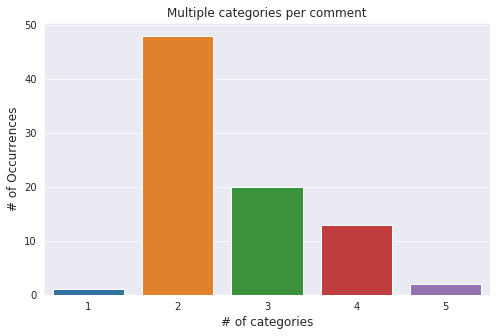

In [6]:
rowsums = df.iloc[:,4:].sum(axis=1)
x=rowsums.value_counts()
#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

## The distribution of the number of words in input texts

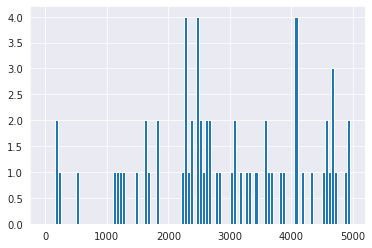

In [5]:
lens = df.all_text_clean.str.len()
lens.hist(bins = np.arange(0,5000,50))

## Holding out 5 rows from the original dataframe for prediction at the end

In [7]:
df_holdout = df.iloc[:5]

df = df.iloc[5:]

In [8]:
df.columns

Index(['Unnamed: 0', 'PIMS_ID', 'all_text_clean', 'all_text_clean_spacy',
       'enabling', 'mainstream', 'alignment', 'advocacy_towards_policy_makers',
       'public_campaign', 'community_engagement'],
      dtype='object')

##  Features engineering

In [9]:
categories = ['mainstream', 'alignment', 'advocacy_towards_policy_makers',
       'public_campaign', 'community_engagement']


#Creating the features (tf-idf weights) for the processed text
texts = df['all_text_clean'].astype('str')

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df = 2, 
                                   max_df = .95)

X = tfidf_vectorizer.fit_transform(texts)

#Turning the labels into numbers
y = pd.DataFrame(df, columns = categories)
#Dimenionality reduction. Only using the 100 best features er category

lsa = TruncatedSVD(n_components=100, 
                   n_iter=10, 
                   random_state=3)

X = lsa.fit_transform(X)


## Train multiple ML models / OneVsRest multi-label strategy

In [10]:
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])
#Creating a dict of the models
model_dict = {
              'Stochastic Gradient Descent' : OneVsRestClassifier(SGDClassifier(random_state=3, loss='log'), n_jobs=1),
              'Random Forest': OneVsRestClassifier(RandomForestClassifier(random_state=3), n_jobs=1),
              'Decsision Tree': OneVsRestClassifier(DecisionTreeClassifier(random_state=3), n_jobs=1),
              'AdaBoost': OneVsRestClassifier(AdaBoostClassifier(random_state=3), n_jobs=1),
              'Gaussian Naive Bayes': OneVsRestClassifier(GaussianNB(), n_jobs=1),
              'K Nearest Neighbor': OneVsRestClassifier(KNeighborsClassifier(), n_jobs=1)}


#Train test split with stratified sampling for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True,  
                                                    random_state = 3)
y_train = y_train.dropna(axis=1)
#Function to get the scores for each model in a df
def model_score_df(model_dict, X_train, X_test, y_train, y_test):   
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():   
        model_name.append(k)
        v.fit(X_train, y_train)
        y_pred = v.predict(X_test)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        p_score_list.append(precision_score(y_test, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    return model_comparison_df


def printTable(myDict, colList=None, sep='\uFFFA'):
    """ Pretty print a list of dictionaries (myDict) as a dynamically sized table.
   If column names (colList) aren't specified, they will show in random order.
   sep: row separator. Ex: sep='\n' on Linux. Default: dummy to not split line.
   Author: Thierry Husson - Use it as you want but don't blame me.
   """
    if not colList: colList = list(myDict[0].keys() if myDict else [])
    myList = [colList] # 1st row = header
    for item in myDict: myList.append([str(item[col] or '') for col in colList])
    colSize = [max(map(len,(sep.join(col)).split(sep))) for col in zip(*myList)]
    formatStr = ' | '.join(["{{:<{}}}".format(i) for i in colSize])
    line = formatStr.replace(' | ','-+-').format(*['-' * i for i in colSize])
    item=myList.pop(0); lineDone=False
    while myList:
        if all(not i for i in item):
            item=myList.pop(0)
            if line and (sep!='\uFFFA' or not lineDone): print(line); lineDone=True
        row = [i.split(sep,1) for i in item]
        print(formatStr.format(*[i[0] for i in row]))
        item = [i[1] if len(i)>1 else '' for i in row]
        

from tabulate import tabulate        
lis = []
for category in categories:
    dic = {}
    dff = model_score_df(model_dict, X_train, X_test, y_train[category], y_test[category])
    # Using DataFrame.insert() to add a column
    dic['Category'] = category
    dic['#Inputs'] = df_stats.number_of_inputs[df_stats['category'] == category]
    dic['Classifiers'] = '    \n '.join(dff.model_name.apply(str).tolist())
    dic['accuracy_score'] = '    \n '.join(dff.accuracy_score.apply(str).tolist()) 
    dic['precision_score'] = '   \n '.join(dff.precision_score.apply(str).tolist())
    dic['recall_score'] = '    \n '.join(dff.recall_score.apply(str).tolist())
    dic['f1_score'] = '    \n '.join(dff.f1_score.apply(str).tolist())
    lis.append(dic)
    
#headers = ['Category', 'Classifiers', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
#print(tabulate(lis, tablefmt='html'))
header = lis[0].keys()
rows =  [x.values() for x in lis]
#print (tabulate(rows, header, tablefmt='html'))


<table>
<thead>
<tr><th>Category                      </th><th style="text-align: right;">  #Inputs</th><th>Classifiers  </th><th>accuracy_score  </th><th>precision_score  </th><th>recall_score  </th><th>f1_score  </th></tr>
</thead>
<tbody>
<tr><td>mainstream                    </td><td style="text-align: right;">       69</td><td>Gaussian Naive Bayes    
 K Nearest Neighbor    
 Decsision Tree    
 Stochastic Gradient Descent    
 Random Forest    
 AdaBoost              </td><td>0.8333333333333334    
 0.9166666666666666    
 0.8333333333333334 <br>   
 0.875    <br>
 0.875    <br>
 0.875        <br>         </td><td>0.7142857142857143   
 0.9565217391304348   
 0.6736842105263158 <br>   
 0.4375   <br>
 0.4375   <br>
 0.4375       <br>           </td><td>0.9047619047619048    
 0.6666666666666666    
 0.7619047619047619    
 0.5    <br>
 0.5    <br>
 0.5        <br>       </td><td>0.7473684210526316    
 0.7272727272727273 <br>   
 0.7    <br>
 0.4666666666666667    
 0.4666666666666667    
 0.4666666666666667           </td></tr>
<tr><td>alignment                     </td><td style="text-align: right;">       13</td><td>Decsision Tree    
 Stochastic Gradient Descent    
 Random Forest    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor              </td><td>0.8333333333333334    
 0.875    <br>
 0.875    <br>
 0.875    <br>
 0.875    <br>
 0.875        <br>         </td><td>0.7   <br>
 0.9347826086956521   
 0.9347826086956521   
 0.9347826086956521   
 0.9347826086956521   
 0.9347826086956521                  </td><td>0.7    <br>
 0.625    <br>
 0.625    <br>
 0.625    <br>
 0.625    <br>
 0.625        <br>       </td><td>0.7    <br>
 0.6651162790697674    
 0.6651162790697674    
 0.6651162790697674    
 0.6651162790697674    
 0.6651162790697674           </td></tr>
<tr><td>advocacy_towards_policy_makers</td><td style="text-align: right;">       14</td><td>Gaussian Naive Bayes    
 K Nearest Neighbor    
 Stochastic Gradient Descent    
 Random Forest    
 Decsision Tree    
 AdaBoost              </td><td>0.7083333333333334    
 0.7083333333333334    
 0.8333333333333334    
 0.8333333333333334    
 0.7916666666666666    
 0.7083333333333334                 </td><td>0.5840336134453781   
 0.5210526315789473   
 0.4166666666666667   
 0.4166666666666667   
 0.41304347826086957   
 0.40476190476190477                  </td><td>0.625  <br>  
 0.525    <br>
 0.5    <br>
 0.5    <br>
 0.475    <br>
 0.425        <br>       </td><td>0.5872235872235871    
 0.5213675213675214    
 0.45454545454545453    
 0.45454545454545453    
 0.44186046511627913    
 0.41463414634146345           </td></tr>
<tr><td>public_campaign               </td><td style="text-align: right;">        7</td><td>Stochastic Gradient Descent    
 Random Forest    
 Decsision Tree    
 AdaBoost    
 K Nearest Neighbor    
 Gaussian Naive Bayes              </td><td>0.9166666666666666    
 0.9166666666666666    
 0.9166666666666666    
 0.9166666666666666    
 0.9166666666666666 <br>    
 0.875        <br>         </td><td>0.4583333333333333   
 0.4583333333333333   
 0.4583333333333333   
 0.4583333333333333   
 0.4583333333333333   
 0.45652173913043476                  </td><td>0.5 <br>   
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.4772727272727273               </td><td>0.4782608695652174    
 0.4782608695652174    
 0.4782608695652174    
 0.4782608695652174    
 0.4782608695652174    
 0.4666666666666666           </td></tr>
<tr><td>community_engagement          </td><td style="text-align: right;">       32</td><td>AdaBoost    
 Stochastic Gradient Descent    
 K Nearest Neighbor    
 Gaussian Naive Bayes    
 Random Forest    
 Decsision Tree              </td><td>0.8333333333333334    
 0.7916666666666666 <br>   
 0.75    <br>
 0.6666666666666666    
 0.7083333333333334  <br>  
 0.625                 </td><td>0.8888888888888888   
 0.8109243697478992   
 0.75   
 0.71875   
 0.8333333333333333   
 0.6428571428571428                  </td><td>0.8    
 0.7642857142857142    
 0.7285714285714285    
 0.7    
 0.65    
 0.5642857142857143               </td><td>0.8125    
 0.7722960151802656    
 0.7333333333333332    
 0.6643356643356644    
 0.6307692307692307    
 0.5252747252747253           </td></tr>
</tbody>
</table>

# tundra

In [21]:
df = pd.read_excel('../data/processed/encoded_labels/Tundra.xlsx')
df.columns

Index(['Unnamed: 0', 'PIMS_ID', 'all_text_clean', 'all_text_clean_spacy',
       'tundra', 'alpine_tundra'],
      dtype='object')

In [23]:
df_labels = df.drop(['Unnamed: 0', 'PIMS_ID', 'all_text_clean', 'all_text_clean_spacy', 'tundra'], axis=1)
counts = []
categories = list(df_labels.columns.values)
for i in categories:
    counts.append((i, df_labels[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_inputs'])
df_stats

,category,number_of_inputs
0,alpine_tundra,1


# conserved_areas

In [24]:
df = pd.read_excel('../data/processed/encoded_labels/Conserved_Areas.xlsx')
df.columns

Index(['Unnamed: 0', 'PIMS_ID', 'all_text_clean', 'all_text_clean_spacy',
       'conserved_areas', '_indigenous_protected_and_conserved_areas_ipcas_x',
       '_indigenous_protected_and_conserved_areas_ipcas_y',
       'marine_and_coastal_protected_areas', 'terrestrial_protected_areas',
       'indigenous_and_communities_conserved_areas_icca',
       'transboundary_conservation_areas', 'productive_landscapes_seascapes',
       'key_biodiversity_areas_kba',
       '_important_bird_and_biodiversity_areas_ibas',
       'specially_protected_areas_spas',
       '_indigenous_protected_and_conserved_areas_ipcas',
       'protected_areas_network',
       'oecm_other_effective_area_based_conservation_measures',
       'locally_managed_marine_areas'],
      dtype='object')

In [26]:
df_labels = df.drop(['Unnamed: 0', 'PIMS_ID', 'all_text_clean', 'all_text_clean_spacy', 'conserved_areas'], axis=1)
counts = []
categories = list(df_labels.columns.values)
for i in categories:
    counts.append((i, df_labels[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_inputs'])
df_stats

,category,number_of_inputs
0,_indigenous_protected_and_conserved_areas_ipcas_x,2
1,_indigenous_protected_and_conserved_areas_ipcas_y,1
2,marine_and_coastal_protected_areas,48
3,terrestrial_protected_areas,76
4,indigenous_and_communities_conserved_areas_icca,23
5,transboundary_conservation_areas,12
6,productive_landscapes_seascapes,56
7,key_biodiversity_areas_kba,51
8,_important_bird_and_biodiversity_areas_ibas,12
9,specially_protected_areas_spas,14


In [29]:
categories = ['_indigenous_protected_and_conserved_areas_ipcas_x',
       '_indigenous_protected_and_conserved_areas_ipcas_y',
       'marine_and_coastal_protected_areas', 'terrestrial_protected_areas',
       'indigenous_and_communities_conserved_areas_icca',
       'transboundary_conservation_areas', 'productive_landscapes_seascapes',
       'key_biodiversity_areas_kba',
       '_important_bird_and_biodiversity_areas_ibas',
       'specially_protected_areas_spas',
       '_indigenous_protected_and_conserved_areas_ipcas',
       'protected_areas_network',
       'oecm_other_effective_area_based_conservation_measures',
       'locally_managed_marine_areas']


#Creating the features (tf-idf weights) for the processed text
texts = df['all_text_clean'].astype('str')

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df = 2, 
                                   max_df = .95)

X = tfidf_vectorizer.fit_transform(texts)

#Turning the labels into numbers
y = pd.DataFrame(df, columns = categories)
#Dimenionality reduction. Only using the 100 best features er category

lsa = TruncatedSVD(n_components=100, 
                   n_iter=10, 
                   random_state=3)

X = lsa.fit_transform(X)
#Creating a dict of the models
model_dict = {
              'Stochastic Gradient Descent' : OneVsRestClassifier(SGDClassifier(random_state=3, loss='log'), n_jobs=1),
              'Random Forest': OneVsRestClassifier(RandomForestClassifier(random_state=3), n_jobs=1),
              'Decsision Tree': OneVsRestClassifier(DecisionTreeClassifier(random_state=3), n_jobs=1),
              'AdaBoost': OneVsRestClassifier(AdaBoostClassifier(random_state=3), n_jobs=1),
              'Gaussian Naive Bayes': OneVsRestClassifier(GaussianNB(), n_jobs=1),
              'K Nearest Neighbor': OneVsRestClassifier(KNeighborsClassifier(), n_jobs=1)}


#Train test split with stratified sampling for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True,  
                                                    random_state = 3)
y_train = y_train.dropna(axis=1)
#Function to get the scores for each model in a df
def model_score_df(model_dict, X_train, X_test, y_train, y_test):   
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():   
        model_name.append(k)
        v.fit(X_train, y_train)
        y_pred = v.predict(X_test)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        p_score_list.append(precision_score(y_test, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    return model_comparison_df


def printTable(myDict, colList=None, sep='\uFFFA'):
    """ Pretty print a list of dictionaries (myDict) as a dynamically sized table.
   If column names (colList) aren't specified, they will show in random order.
   sep: row separator. Ex: sep='\n' on Linux. Default: dummy to not split line.
   Author: Thierry Husson - Use it as you want but don't blame me.
   """
    if not colList: colList = list(myDict[0].keys() if myDict else [])
    myList = [colList] # 1st row = header
    for item in myDict: myList.append([str(item[col] or '') for col in colList])
    colSize = [max(map(len,(sep.join(col)).split(sep))) for col in zip(*myList)]
    formatStr = ' | '.join(["{{:<{}}}".format(i) for i in colSize])
    line = formatStr.replace(' | ','-+-').format(*['-' * i for i in colSize])
    item=myList.pop(0); lineDone=False
    while myList:
        if all(not i for i in item):
            item=myList.pop(0)
            if line and (sep!='\uFFFA' or not lineDone): print(line); lineDone=True
        row = [i.split(sep,1) for i in item]
        print(formatStr.format(*[i[0] for i in row]))
        item = [i[1] if len(i)>1 else '' for i in row]
        

from tabulate import tabulate        
lis = []
for category in categories:
    dic = {}
    dff = model_score_df(model_dict, X_train, X_test, y_train[category], y_test[category])
    # Using DataFrame.insert() to add a column
    dic['Category'] = category
    dic['#Inputs'] = df_stats.number_of_inputs[df_stats['category'] == category]
    dic['Classifiers'] = '    \n '.join(dff.model_name.apply(str).tolist())
    dic['accuracy_score'] = '    \n '.join(dff.accuracy_score.apply(str).tolist()) 
    dic['precision_score'] = '   \n '.join(dff.precision_score.apply(str).tolist())
    dic['recall_score'] = '    \n '.join(dff.recall_score.apply(str).tolist())
    dic['f1_score'] = '    \n '.join(dff.f1_score.apply(str).tolist())
    lis.append(dic)
    
#headers = ['Category', 'Classifiers', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
#print(tabulate(lis, tablefmt='html'))
header = lis[0].keys()
rows =  [x.values() for x in lis]
#print (tabulate(rows, header, tablefmt='html'))

<table>
<thead>
<tr><th>Category                                             </th><th style="text-align: right;">  #Inputs</th><th>Classifiers  </th><th>accuracy_score  </th><th>precision_score  </th><th>recall_score  </th><th>f1_score  </th></tr>
</thead>
<tbody>
<tr><td>_indigenous_protected_and_conserved_areas_ipcas_x    </td><td style="text-align: right;">        2</td><td>Random Forest    <br>
 Decsision Tree   <br> 
 Gaussian Naive Bayes <br>   
 K Nearest Neighbor <br>   
 Stochastic Gradient Descent  <br>  
 AdaBoost              </td><td>1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 0.9782608695652174    
 0.9782608695652174                 </td><td>1.0   <br>
 1.0   <br>
 1.0   <br>
 1.0   <br>
 0.5   <br>
 0.5       <br>           </td><td>1.0   <br> 
 1.0    <br>
 1.0    <br>
 1.0    <br>
 0.4891304347826087    
 0.4891304347826087               </td><td>1.0   <br> 
 1.0    <br>
 1.0    <br>
 1.0    <br>
 0.4945054945054945    
 0.4945054945054945           </td></tr>
<tr><td>_indigenous_protected_and_conserved_areas_ipcas_y    </td><td style="text-align: right;">        1</td><td>Stochastic Gradient Descent    
 Random Forest    
 Decsision Tree    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor              </td><td>1.0   <br> 
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0        <br>         </td><td>1.0   <br>
 1.0   <br>
 1.0   <br>
 1.0   <br>
 1.0   <br>
 1.0                  </td><td>1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0        <br>       </td><td>1.0  <br>  
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0           </td></tr>
<tr><td>marine_and_coastal_protected_areas                   </td><td style="text-align: right;">       48</td><td>Random Forest    
 Decsision Tree    
 K Nearest Neighbor    
 Stochastic Gradient Descent    
 AdaBoost    
 Gaussian Naive Bayes              </td><td>0.8913043478260869    
 0.8260869565217391    
 0.8260869565217391    
 0.8478260869565217    
 0.8043478260869565    
 0.782608695652174                 </td><td>0.9418604651162791   
 0.7083333333333333   
 0.7083333333333333   
 0.7390243902439024   
 0.6681681681681682   
 0.5916666666666667                  </td><td>0.6875    
 0.7467105263157895    
 0.7467105263157895    
 0.6611842105263157    
 0.6842105263157895    
 0.5723684210526316               </td><td>0.7418630751964086    
 0.7237237237237237    
 0.7237237237237237    
 0.6864654333008764    
 0.6752941176470588    
 0.5787545787545788           </td></tr>
<tr><td>terrestrial_protected_areas                          </td><td style="text-align: right;">       76</td><td>K Nearest Neighbor    
 Random Forest    
 AdaBoost    
 Gaussian Naive Bayes    
 Decsision Tree    
 Stochastic Gradient Descent              </td><td>0.6521739130434783    
 0.6521739130434783    
 0.6304347826086957    
 0.6086956521739131    
 0.5652173913043478    
 0.5217391304347826                 </td><td>0.6519230769230769   
 0.6646825396825397   
 0.6304347826086957   
 0.6383928571428572   
 0.5791666666666666   
 0.5625                  </td><td>0.6496212121212122    
 0.6571969696969697    
 0.6306818181818181    
 0.6174242424242424    
 0.571969696969697    
 0.5359848484848485               </td><td>0.6495238095238096    
 0.6495238095238095    
 0.630260047281324    
 0.5964912280701754    
 0.5576923076923077    
 0.47291666666666665           </td></tr>
<tr><td>indigenous_and_communities_conserved_areas_icca      </td><td style="text-align: right;">       23</td><td>Decsision Tree    
 Stochastic Gradient Descent    
 Random Forest    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 AdaBoost              </td><td>0.782608695652174    
 0.8260869565217391    
 0.8260869565217391    
 0.8043478260869565    
 0.8043478260869565    
 0.782608695652174                 </td><td>0.5916666666666667   
 0.6704545454545454   
 0.41304347826086957   
 0.4111111111111111   
 0.4111111111111111   
 0.4090909090909091                  </td><td>0.5723684210526316    
 0.549342105263158    
 0.5    
 0.4868421052631579    
 0.4868421052631579    
 0.47368421052631576               </td><td>0.5787545787545788    
 0.551219512195122    
 0.45238095238095233    
 0.4457831325301205    
 0.4457831325301205    
 0.43902439024390244           </td></tr>
<tr><td>transboundary_conservation_areas                     </td><td style="text-align: right;">       12</td><td>Gaussian Naive Bayes    
 Decsision Tree    
 Random Forest    
 K Nearest Neighbor    
 Stochastic Gradient Descent    
 AdaBoost              </td><td>0.9782608695652174    
 0.8913043478260869    
 0.9782608695652174    
 0.9782608695652174    
 0.9565217391304348    
 0.9565217391304348                 </td><td>0.75   <br>
 0.5833333333333334   
 0.4891304347826087   
 0.4891304347826087   
 0.4888888888888889   
 0.4888888888888889                  </td><td>0.9888888888888889    
 0.9444444444444444<br>    
 0.5  <br>  
 0.5    <br>
 0.4888888888888889    
 0.4888888888888889               </td><td>0.8277153558052435    
 0.6134453781512605    
 0.4945054945054945    
 0.4945054945054945    
 0.4888888888888889    
 0.4888888888888889           </td></tr>
<tr><td>productive_landscapes_seascapes                      </td><td style="text-align: right;">       56</td><td>Decsision Tree    
 Stochastic Gradient Descent    
 K Nearest Neighbor    
 Gaussian Naive Bayes    
 AdaBoost    
 Random Forest              </td><td>0.717391304347826    
 0.6956521739130435    
 0.6521739130434783    
 0.717391304347826    
 0.5869565217391305    
 0.6956521739130435                 </td><td>0.6470588235294117   
 0.6247086247086246   
 0.6024340770791075   
 0.631578947368421   
 0.5229166666666667   
 0.35555555555555557                  </td><td>0.6398601398601399    
 0.6247086247086246    
 0.6177156177156178    
 0.5932400932400932    
 0.5256410256410257    
 0.48484848484848486               </td><td>0.6429850746268657    
 0.6247086247086246    
 0.6043010752688172    
 0.5989268947015426    
 0.5216201423097975    
 0.41025641025641024           </td></tr>
<tr><td>key_biodiversity_areas_kba                           </td><td style="text-align: right;">       51</td><td>AdaBoost    
 Gaussian Naive Bayes    
 Decsision Tree    
 Stochastic Gradient Descent    
 Random Forest    
 K Nearest Neighbor              </td><td>0.6956521739130435    
 0.7391304347826086    
 0.6304347826086957    
 0.6739130434782609    
 0.7391304347826086    
 0.6086956521739131                 </td><td>0.6490872210953347   
 0.6696696696696697   
 0.6038461538461539   
 0.5906862745098039   
 0.8666666666666667   
 0.4935064935064935                  </td><td>0.6713286713286714    
 0.6317016317016317    
 0.6258741258741258    
 0.5862470862470862    
 0.5384615384615384    
 0.4941724941724942               </td><td>0.6537634408602151    
 0.6415584415584416    
 0.5983564458140729    
 0.5880597014925373    
 0.49450549450549447    
 0.49264705882352944           </td></tr>
<tr><td>_important_bird_and_biodiversity_areas_ibas          </td><td style="text-align: right;">       12</td><td>Stochastic Gradient Descent    
 Random Forest    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 Decsision Tree              </td><td>0.9782608695652174    
 0.9782608695652174    
 0.9782608695652174    
 0.9782608695652174    
 0.9782608695652174    
 0.9565217391304348                 </td><td>0.4891304347826087   
 0.4891304347826087   
 0.4891304347826087   
 0.4891304347826087   
 0.4891304347826087   
 0.4888888888888889                  </td><td>0.5    <br>
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.4888888888888889               </td><td>0.4945054945054945    
 0.4945054945054945    
 0.4945054945054945    
 0.4945054945054945    
 0.4945054945054945    
 0.4888888888888889           </td></tr>
<tr><td>specially_protected_areas_spas                       </td><td style="text-align: right;">       14</td><td>Random Forest    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 Stochastic Gradient Descent    
 Decsision Tree              </td><td>0.9565217391304348    
 0.9565217391304348    
 0.9565217391304348    
 0.9565217391304348    
 0.9347826086956522    
 0.8695652173913043                 </td><td>0.4782608695652174   
 0.4782608695652174   
 0.4782608695652174   
 0.4782608695652174   
 0.4777777777777778   
 0.47619047619047616                  </td><td>0.5  <br>  
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.48863636363636365    
 0.45454545454545453               </td><td>0.4888888888888889    
 0.4888888888888889    
 0.4888888888888889    
 0.4888888888888889    
 0.4831460674157304    
 0.46511627906976744           </td></tr>
<tr><td>_indigenous_protected_and_conserved_areas_ipcas      </td><td style="text-align: right;">        0</td><td>Stochastic Gradient Descent    
 Random Forest    
 Decsision Tree    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor              </td><td>1.0  <br>  
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0        <br>         </td><td>1.0   <br>
 1.0   <br>
 1.0   <br>
 1.0   <br>
 1.0   <br>
 1.0       <br>           </td><td>1.0 <br>   
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0        <br>       </td><td>1.0   <br> 
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0        <br>   </td></tr>
<tr><td>protected_areas_network                              </td><td style="text-align: right;">        7</td><td>Random Forest    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 Stochastic Gradient Descent    
 Decsision Tree              </td><td>0.9782608695652174    
 0.9782608695652174    
 0.9782608695652174    
 0.9782608695652174    
 0.9565217391304348    
 0.9347826086956522                 </td><td>0.4891304347826087   
 0.4891304347826087   
 0.4891304347826087   
 0.4891304347826087   
 0.4888888888888889   
 0.48863636363636365                  </td><td>0.5    <br>
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.4888888888888889    
 0.4777777777777778               </td><td>0.4945054945054945    
 0.4945054945054945    
 0.4945054945054945    
 0.4945054945054945    
 0.4888888888888889    
 0.4831460674157304           </td></tr>
<tr><td>oecm_other_effective_area_based_conservation_measures</td><td style="text-align: right;">       18</td><td>Random Forest    
 K Nearest Neighbor    
 Stochastic Gradient Descent    
 AdaBoost    
 Gaussian Naive Bayes    
 Decsision Tree              </td><td>0.9130434782608695    
 0.9130434782608695    
 0.8913043478260869    
 0.8913043478260869    
 0.8260869565217391    
 0.8043478260869565                 </td><td>0.45652173913043476   
 0.45652173913043476   
 0.45555555555555555   
 0.45555555555555555   
 0.4523809523809524   
 0.45121951219512196                  </td><td>0.5  <br>  
 0.5    <br>
 0.4880952380952381    
 0.4880952380952381    
 0.4523809523809524    
 0.44047619047619047               </td><td>0.47727272727272724    
 0.47727272727272724    
 0.47126436781609193    
 0.47126436781609193    
 0.4523809523809524    
 0.44578313253012053           </td></tr>
<tr><td>locally_managed_marine_areas                         </td><td style="text-align: right;">       15</td><td>AdaBoost    
 Stochastic Gradient Descent    
 Random Forest    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 Decsision Tree              </td><td>0.9782608695652174    
 0.9782608695652174    
 0.9782608695652174    
 0.9782608695652174    
 0.9782608695652174    
 0.8695652173913043                 </td><td>0.75   
 0.4891304347826087   
 0.4891304347826087   
 0.4891304347826087   
 0.4891304347826087   
 0.4878048780487805                  </td><td>0.9888888888888889    <br>
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.4444444444444444               </td><td>0.8277153558052435    
 0.4945054945054945    
 0.4945054945054945    
 0.4945054945054945    
 0.4945054945054945    
 0.46511627906976744           </td></tr>
</tbody>
</table>

# Finance Economy

In [12]:
df = pd.read_excel('../data/processed/encoded_labels/Finance_Economy.xlsx')
df.columns

Index(['Unnamed: 0', 'PIMS_ID', 'all_text_clean', 'all_text_clean_spacy',
       'finance_economy', 'nature_finance', 'energy_finance',
       'circular_economy', 'blue_economy', 'green_economy', 'fiscal_planning',
       'new_other_financial_schemes_mechanism'],
      dtype='object')

In [13]:
df_labels = df.drop(['Unnamed: 0', 'PIMS_ID', 'all_text_clean', 'all_text_clean_spacy', 'finance_economy'], axis=1)
counts = []
categories = list(df_labels.columns.values)
for i in categories:
    counts.append((i, df_labels[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_inputs'])
df_stats

,category,number_of_inputs
0,nature_finance,42
1,energy_finance,62
2,circular_economy,1
3,blue_economy,8
4,green_economy,14
5,fiscal_planning,28
6,new_other_financial_schemes_mechanism,49


In [14]:
categories = ['nature_finance', 'energy_finance',
       'circular_economy', 'blue_economy', 'green_economy', 'fiscal_planning',
       'new_other_financial_schemes_mechanism']


#Creating the features (tf-idf weights) for the processed text
texts = df['all_text_clean'].astype('str')

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df = 2, 
                                   max_df = .95)

X = tfidf_vectorizer.fit_transform(texts)

#Turning the labels into numbers
y = pd.DataFrame(df, columns = categories)
#Dimenionality reduction. Only using the 100 best features er category

lsa = TruncatedSVD(n_components=100, 
                   n_iter=10, 
                   random_state=3)

X = lsa.fit_transform(X)
#Creating a dict of the models
model_dict = {
              'Stochastic Gradient Descent' : OneVsRestClassifier(SGDClassifier(random_state=3, loss='log'), n_jobs=1),
              'Random Forest': OneVsRestClassifier(RandomForestClassifier(random_state=3), n_jobs=1),
              'Decsision Tree': OneVsRestClassifier(DecisionTreeClassifier(random_state=3), n_jobs=1),
              'AdaBoost': OneVsRestClassifier(AdaBoostClassifier(random_state=3), n_jobs=1),
              'Gaussian Naive Bayes': OneVsRestClassifier(GaussianNB(), n_jobs=1),
              'K Nearest Neighbor': OneVsRestClassifier(KNeighborsClassifier(), n_jobs=1)}


#Train test split with stratified sampling for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True,  
                                                    random_state = 3)
y_train = y_train.dropna(axis=1)
#Function to get the scores for each model in a df
def model_score_df(model_dict, X_train, X_test, y_train, y_test):   
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():   
        model_name.append(k)
        v.fit(X_train, y_train)
        y_pred = v.predict(X_test)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        p_score_list.append(precision_score(y_test, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    return model_comparison_df


def printTable(myDict, colList=None, sep='\uFFFA'):
    """ Pretty print a list of dictionaries (myDict) as a dynamically sized table.
   If column names (colList) aren't specified, they will show in random order.
   sep: row separator. Ex: sep='\n' on Linux. Default: dummy to not split line.
   Author: Thierry Husson - Use it as you want but don't blame me.
   """
    if not colList: colList = list(myDict[0].keys() if myDict else [])
    myList = [colList] # 1st row = header
    for item in myDict: myList.append([str(item[col] or '') for col in colList])
    colSize = [max(map(len,(sep.join(col)).split(sep))) for col in zip(*myList)]
    formatStr = ' | '.join(["{{:<{}}}".format(i) for i in colSize])
    line = formatStr.replace(' | ','-+-').format(*['-' * i for i in colSize])
    item=myList.pop(0); lineDone=False
    while myList:
        if all(not i for i in item):
            item=myList.pop(0)
            if line and (sep!='\uFFFA' or not lineDone): print(line); lineDone=True
        row = [i.split(sep,1) for i in item]
        print(formatStr.format(*[i[0] for i in row]))
        item = [i[1] if len(i)>1 else '' for i in row]
        

from tabulate import tabulate        
lis = []
for category in categories:
    dic = {}
    dff = model_score_df(model_dict, X_train, X_test, y_train[category], y_test[category])
    # Using DataFrame.insert() to add a column
    dic['Category'] = category
    dic['#Inputs'] = df_stats.number_of_inputs[df_stats['category'] == category]
    dic['Classifiers'] = '    \n '.join(dff.model_name.apply(str).tolist())
    dic['accuracy_score'] = '    \n '.join(dff.accuracy_score.apply(str).tolist()) 
    dic['precision_score'] = '   \n '.join(dff.precision_score.apply(str).tolist())
    dic['recall_score'] = '    \n '.join(dff.recall_score.apply(str).tolist())
    dic['f1_score'] = '    \n '.join(dff.f1_score.apply(str).tolist())
    lis.append(dic)
    
#headers = ['Category', 'Classifiers', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
#print(tabulate(lis, tablefmt='html'))
header = lis[0].keys()
rows =  [x.values() for x in lis]

#print (tabulate(rows, header, tablefmt='html'))

<table>
<thead>
<tr><th>Category                             </th><th style="text-align: right;">  #Inputs</th><th>Classifiers  </th><th>accuracy_score  </th><th>precision_score  </th><th>recall_score  </th><th>f1_score  </th></tr>
</thead>
<tbody>
<tr><td>nature_finance                       </td><td style="text-align: right;">       42</td><td>Decsision Tree    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 Random Forest    
 Stochastic Gradient Descent              </td><td>0.8367346938775511    
 0.7755102040816326    
 0.7346938775510204    
 0.8163265306122449    
 0.8163265306122449    
 0.7346938775510204                 </td><td>0.7792792792792793   
 0.6997863247863247   
 0.6868421052631579   
 0.8090909090909091   
 0.9021739130434783   
 0.5471014492753623                  </td><td>0.7792792792792793    
 0.7105855855855856    
 0.7398648648648649    
 0.6531531531531531    
 0.625    
 0.5146396396396397               </td><td>0.7792792792792793    
 0.7046575342465753    
 0.693307655272027    
 0.6797385620915033    
 0.6457831325301204    
 0.48835341365461854           </td></tr>
<tr><td>energy_finance                       </td><td style="text-align: right;">       62</td><td>Stochastic Gradient Descent    
 AdaBoost    
 Gaussian Naive Bayes    
 Random Forest    
 Decsision Tree    
 K Nearest Neighbor              </td><td>0.9591836734693877    
 0.9591836734693877    
 0.9591836734693877    
 0.9387755102040817    
 0.9387755102040817    
 0.8775510204081632                 </td><td>0.9696969696969697   
 0.9696969696969697   
 0.9696969696969697   
 0.9558823529411764   
 0.9558823529411764   
 0.9189189189189189                  </td><td>0.9444444444444444    
 0.9444444444444444    
 0.9444444444444444    
 0.9166666666666667    
 0.9166666666666667    
 0.8333333333333333               </td><td>0.9549632352941176    
 0.9549632352941176    
 0.9549632352941176    
 0.9314685314685315    
 0.9314685314685315    
 0.8558823529411765           </td></tr>
<tr><td>circular_economy                     </td><td style="text-align: right;">        1</td><td>Stochastic Gradient Descent    
 Random Forest    
 Decsision Tree    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor              </td><td>1.0    
 1.0    
 1.0    
 1.0    
 1.0    
 1.0                 </td><td>1.0   
 1.0   
 1.0   
 1.0   
 1.0   
 1.0                  </td><td>1.0    
 1.0    
 1.0    
 1.0    
 1.0    
 1.0               </td><td>1.0    
 1.0    
 1.0    
 1.0    
 1.0    
 1.0           </td></tr>
<tr><td>blue_economy                         </td><td style="text-align: right;">        8</td><td>Stochastic Gradient Descent    
 Random Forest    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 Decsision Tree              </td><td>0.9387755102040817    
 0.9387755102040817    
 0.9387755102040817    
 0.9387755102040817    
 0.9387755102040817    
 0.9183673469387755                 </td><td>0.46938775510204084   
 0.46938775510204084   
 0.46938775510204084   
 0.46938775510204084   
 0.46938775510204084   
 0.46875                  </td><td>0.5    
 0.5    
 0.5    
 0.5    
 0.5    
 0.4891304347826087               </td><td>0.4842105263157895    
 0.4842105263157895    
 0.4842105263157895    
 0.4842105263157895    
 0.4842105263157895    
 0.4787234042553192           </td></tr>
<tr><td>green_economy                        </td><td style="text-align: right;">       14</td><td>K Nearest Neighbor    
 Gaussian Naive Bayes    
 Decsision Tree    
 Stochastic Gradient Descent    
 Random Forest    
 AdaBoost              </td><td>0.9387755102040817    
 0.8979591836734694    
 0.8367346938775511    
 0.9591836734693877    
 0.9591836734693877    
 0.9591836734693877                 </td><td>0.6557971014492754   
 0.5886363636363636   
 0.5503048780487805   
 0.47959183673469385   
 0.47959183673469385   
 0.47959183673469385                  </td><td>0.7287234042553192    
 0.7074468085106382    
 0.675531914893617    
 0.5    
 0.5    
 0.5               </td><td>0.6838709677419355    
 0.6153846153846154    
 0.5545454545454546    
 0.4895833333333333    
 0.4895833333333333    
 0.4895833333333333           </td></tr>
<tr><td>fiscal_planning                      </td><td style="text-align: right;">       28</td><td>K Nearest Neighbor    
 Stochastic Gradient Descent    
 Gaussian Naive Bayes    
 AdaBoost    
 Decsision Tree    
 Random Forest              </td><td>0.8571428571428571    
 0.8775510204081632    
 0.8367346938775511    
 0.7959183673469388    
 0.7755102040816326    
 0.8775510204081632                 </td><td>0.7243589743589743   
 0.75   
 0.6847222222222222   
 0.6166666666666667   
 0.5987179487179487   
 0.9375                  </td><td>0.7976190476190477    
 0.75    
 0.7261904761904762    
 0.6428571428571428    
 0.6309523809523809    
 0.5714285714285714               </td><td>0.7509077705156135    
 0.75    
 0.7012195121951219    
 0.6265243902439024    
 0.6085693536673928    
 0.5916666666666667           </td></tr>
<tr><td>new_other_financial_schemes_mechanism</td><td style="text-align: right;">       49</td><td>Random Forest    
 Stochastic Gradient Descent    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 Decsision Tree              </td><td>0.8775510204081632    
 0.7959183673469388    
 0.7551020408163265    
 0.7755102040816326    
 0.7551020408163265    
 0.6326530612244898                 </td><td>0.8690476190476191   
 0.7334558823529411   
 0.7035087719298245   
 0.6928571428571428   
 0.6884191176470589   
 0.5745614035087719                  </td><td>0.7595693779904307    
 0.8038277511961722    
 0.777511961722488    
 0.7260765550239234    
 0.7452153110047848    
 0.6016746411483254               </td><td>0.7958333333333333    
 0.75    
 0.7117647058823529    
 0.7046575342465753    
 0.7    
 0.5676470588235294           </td></tr>
</tbody>
</table>

# Governance

In [16]:
df = pd.read_excel('../data/processed/encoded_labels/governance.xlsx')
df.columns

Index(['Unnamed: 0', 'PIMS_ID', 'all_text_clean', 'all_text_clean_spacy',
       'governance', 'institutional_framework', 'partnerships',
       'transboundary_governance', 'inter_sectoral_coordination',
       'adaptive_governance', '_community_governance', '_cooperative',
       '_co_management'],
      dtype='object')

In [17]:
df_labels = df.drop(['Unnamed: 0', 'PIMS_ID', 'all_text_clean', 'all_text_clean_spacy', 'governance'], axis=1)
counts = []
categories = list(df_labels.columns.values)
for i in categories:
    counts.append((i, df_labels[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_inputs'])

categories = ['institutional_framework', 'partnerships',
       'transboundary_governance', 'inter_sectoral_coordination',
       'adaptive_governance', '_community_governance', '_cooperative',
       '_co_management']


#Creating the features (tf-idf weights) for the processed text
texts = df['all_text_clean'].astype('str')

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df = 2, 
                                   max_df = .95)

X = tfidf_vectorizer.fit_transform(texts)

#Turning the labels into numbers
y = pd.DataFrame(df, columns = categories)
#Dimenionality reduction. Only using the 100 best features er category

lsa = TruncatedSVD(n_components=100, 
                   n_iter=10, 
                   random_state=3)

X = lsa.fit_transform(X)
#Creating a dict of the models
model_dict = {
              'Stochastic Gradient Descent' : OneVsRestClassifier(SGDClassifier(random_state=3, loss='log'), n_jobs=1),
              'Random Forest': OneVsRestClassifier(RandomForestClassifier(random_state=3), n_jobs=1),
              'Decsision Tree': OneVsRestClassifier(DecisionTreeClassifier(random_state=3), n_jobs=1),
              'AdaBoost': OneVsRestClassifier(AdaBoostClassifier(random_state=3), n_jobs=1),
              'Gaussian Naive Bayes': OneVsRestClassifier(GaussianNB(), n_jobs=1),
              'K Nearest Neighbor': OneVsRestClassifier(KNeighborsClassifier(), n_jobs=1)}


#Train test split with stratified sampling for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True,  
                                                    random_state = 3)
y_train = y_train.dropna(axis=1)
#Function to get the scores for each model in a df
def model_score_df(model_dict, X_train, X_test, y_train, y_test):   
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():   
        model_name.append(k)
        v.fit(X_train, y_train)
        y_pred = v.predict(X_test)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        p_score_list.append(precision_score(y_test, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    return model_comparison_df


def printTable(myDict, colList=None, sep='\uFFFA'):
    """ Pretty print a list of dictionaries (myDict) as a dynamically sized table.
   If column names (colList) aren't specified, they will show in random order.
   sep: row separator. Ex: sep='\n' on Linux. Default: dummy to not split line.
   Author: Thierry Husson - Use it as you want but don't blame me.
   """
    if not colList: colList = list(myDict[0].keys() if myDict else [])
    myList = [colList] # 1st row = header
    for item in myDict: myList.append([str(item[col] or '') for col in colList])
    colSize = [max(map(len,(sep.join(col)).split(sep))) for col in zip(*myList)]
    formatStr = ' | '.join(["{{:<{}}}".format(i) for i in colSize])
    line = formatStr.replace(' | ','-+-').format(*['-' * i for i in colSize])
    item=myList.pop(0); lineDone=False
    while myList:
        if all(not i for i in item):
            item=myList.pop(0)
            if line and (sep!='\uFFFA' or not lineDone): print(line); lineDone=True
        row = [i.split(sep,1) for i in item]
        print(formatStr.format(*[i[0] for i in row]))
        item = [i[1] if len(i)>1 else '' for i in row]
        

from tabulate import tabulate        
lis = []
for category in categories:
    dic = {}
    dff = model_score_df(model_dict, X_train, X_test, y_train[category], y_test[category])
    # Using DataFrame.insert() to add a column
    dic['Category'] = category
    dic['#Inputs'] = df_stats.number_of_inputs[df_stats['category'] == category]
    dic['Classifiers'] = '    \n '.join(dff.model_name.apply(str).tolist())
    dic['accuracy_score'] = '    \n '.join(dff.accuracy_score.apply(str).tolist()) 
    dic['precision_score'] = '   \n '.join(dff.precision_score.apply(str).tolist())
    dic['recall_score'] = '    \n '.join(dff.recall_score.apply(str).tolist())
    dic['f1_score'] = '    \n '.join(dff.f1_score.apply(str).tolist())
    lis.append(dic)
    
#headers = ['Category', 'Classifiers', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
#print(tabulate(lis, tablefmt='html'))
header = lis[0].keys()
rows =  [x.values() for x in lis]

#print (tabulate(rows, header, tablefmt='html'))

<table>
<thead>
<tr><th>Category                   </th><th style="text-align: right;">  #Inputs</th><th>Classifiers  </th><th>accuracy_score  </th><th>precision_score  </th><th>recall_score  </th><th>f1_score  </th></tr>
</thead>
<tbody>
<tr><td>institutional_framework    </td><td style="text-align: right;">      162</td><td>Random Forest    
 Stochastic Gradient Descent    
 Gaussian Naive Bayes    
 Decsision Tree    
 K Nearest Neighbor    
 AdaBoost              </td><td>0.8591549295774648    
 0.7605633802816901    
 0.7746478873239436    
 0.7183098591549296    
 0.7605633802816901    
 0.704225352112676                 </td><td>0.9253731343283582   
 0.6410675381263616   
 0.6441102756892231   
 0.6343085106382979   
 0.6285714285714286   
 0.5966666666666667                  </td><td>0.6428571428571428    
 0.6622807017543859    
 0.6441102756892231    
 0.6898496240601504    
 0.6353383458646616    
 0.6271929824561404               </td><td>0.681899641577061    
 0.6492298750363267    
 0.6441102756892231    
 0.6406882591093118    
 0.6316753127860848    
 0.6018691588785048           </td></tr>
<tr><td>partnerships               </td><td style="text-align: right;">       79</td><td>K Nearest Neighbor    
 AdaBoost    
 Decsision Tree    
 Stochastic Gradient Descent    
 Random Forest    
 Gaussian Naive Bayes              </td><td>0.6619718309859155    
 0.6338028169014085    
 0.6056338028169014    
 0.5492957746478874    
 0.6056338028169014    
 0.5633802816901409                 </td><td>0.6547619047619048   
 0.6083333333333334   
 0.5797872340425532   
 0.503921568627451   
 0.5559701492537313   
 0.46505376344086025                  </td><td>0.6025747508305648    
 0.5917774086378738    
 0.574750830564784    
 0.5033222591362125    
 0.5124584717607974    
 0.4838039867109634               </td><td>0.5942857142857143    
 0.5908687943262412    
 0.5752136752136752    
 0.4964539007092198    
 0.4352272727272727    
 0.43346203346203344           </td></tr>
<tr><td>transboundary_governance   </td><td style="text-align: right;">       24</td><td>Stochastic Gradient Descent    
 AdaBoost    
 Gaussian Naive Bayes    
 Random Forest    
 K Nearest Neighbor    
 Decsision Tree              </td><td>0.9577464788732394    
 0.9154929577464789    
 0.9154929577464789    
 0.9154929577464789    
 0.9014084507042254    
 0.7183098591549296                 </td><td>0.9129464285714286   
 0.8025641025641026   
 0.8025641025641026   
 0.9565217391304348   
 0.95   
 0.47431077694235585                  </td><td>0.8670634920634921    
 0.7341269841269842    
 0.7341269841269842    
 0.625    
 0.5625    
 0.4593253968253968               </td><td>0.8881889763779527    
 0.7622767857142858    
 0.7622767857142858    
 0.6772727272727272    
 0.5847953216374269    
 0.46212121212121215           </td></tr>
<tr><td>inter_sectoral_coordination</td><td style="text-align: right;">       51</td><td>K Nearest Neighbor    
 AdaBoost    
 Decsision Tree    
 Stochastic Gradient Descent    
 Gaussian Naive Bayes    
 Random Forest              </td><td>0.7746478873239436    
 0.8028169014084507    
 0.7746478873239436    
 0.7464788732394366    
 0.7464788732394366    
 0.8450704225352113                 </td><td>0.5935013262599469   
 0.6021505376344086   
 0.5696969696969697   
 0.5464190981432361   
 0.5159090909090909   
 0.4225352112676056                  </td><td>0.6068181818181818    
 0.5863636363636364    
 0.5696969696969697    
 0.553030303030303   <br> 
 0.5159090909090909    <br>
 0.5               </td><td>0.5988700564971752    
 0.5926229508196722    
 0.5696969696969697    
 0.548728813559322    
 0.5159090909090909    
 0.4580152671755725           </td></tr>
<tr><td>adaptive_governance        </td><td style="text-align: right;">       25</td><td>Stochastic Gradient Descent    
 Gaussian Naive Bayes    
 Random Forest    
 K Nearest Neighbor    
 AdaBoost    
 Decsision Tree              </td><td>0.8873239436619719    
 0.8873239436619719    
 0.9154929577464789    
 0.9154929577464789    
 0.8873239436619719    
 0.8169014084507042                 </td><td>0.5876865671641791   
 0.5876865671641791   
 0.45774647887323944   
 0.45774647887323944   
 0.45652173913043476  <br> 
 0.453125                 <br> </td><td>0.5602564102564103    
 0.5602564102564103   <br> 
 0.5    <br>
 0.5    <br>
 0.4846153846153846    
 0.4461538461538462               </td><td>0.5696969696969697    
 0.5696969696969697    
 0.4779411764705882    
 0.4779411764705882    
 0.47014925373134325    
 0.4496124031007752           </td></tr>
<tr><td>_community_governance      </td><td style="text-align: right;">       29</td><td>Decsision Tree    
 Gaussian Naive Bayes    
 Stochastic Gradient Descent    
 Random Forest    
 K Nearest Neighbor    
 AdaBoost              </td><td>0.8450704225352113    
 0.8591549295774648    
 0.8450704225352113    
 0.8732394366197183    
 0.8591549295774648    
 0.8450704225352113                 </td><td>0.6398809523809523   
 0.6078431372549019   
 0.5652985074626866   
 0.43661971830985913   
 0.4357142857142857   
 0.43478260869565216                  </td><td>0.6263440860215054    
 0.5394265232974911    
 0.5313620071684588  <br>  
 0.5    <br>
 0.49193548387096775    
 0.4838709677419355               </td><td>0.6324705882352941    
 0.5448717948717948    
 0.5342874180083482    
 0.46616541353383456    
 0.4621212121212121    
 0.45801526717557256           </td></tr>
<tr><td>_cooperative               </td><td style="text-align: right;">        3</td><td>Stochastic Gradient Descent    
 Random Forest    
 Decsision Tree    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor              </td><td>1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0        <br>         </td><td>1.0   <br>
 1.0   <br>
 1.0   <br>
 1.0   <br>
 1.0   <br>
 1.0       <br>           </td><td>1.0   <br> 
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0        <br>       </td><td>1.0   <br> 
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0        <br>   </td></tr>
<tr><td>_co_management             </td><td style="text-align: right;">       22</td><td>AdaBoost    
 Stochastic Gradient Descent    
 Random Forest    
 K Nearest Neighbor    
 Decsision Tree    
 Gaussian Naive Bayes              </td><td>0.9014084507042254    
 0.8732394366197183    
 0.9154929577464789    
 0.9154929577464789    
 0.8309859154929577    
 0.8169014084507042                 </td><td>0.6299019607843137   
 0.5621212121212121   
 0.45774647887323944   
 0.45774647887323944   
 0.45384615384615384   
 0.453125                  </td><td>0.5679487179487179    
 0.5525641025641026    
 0.5    
 0.5    
 0.45384615384615384    
 0.4461538461538462               </td><td>0.5847953216374269    
 0.556557945870923    
 0.4779411764705882    
 0.4779411764705882    
 0.4538461538461538    
 0.4496124031007752           </td></tr>
</tbody>
</table>

# Law regulation

In [19]:
df = pd.read_excel('../data/processed/encoded_labels/law_regulation.xlsx')
df.columns

Index(['Unnamed: 0', 'PIMS_ID', 'all_text_clean', 'all_text_clean_spacy',
       'law_regulation', 'laws_policy_plan_formulation',
       'standards_labeling_guideline', 'laws_enforcement_regulation',
       'pollution_control', 'surveillance_compliance',
       'land_rights_and_tenure_security', 'conflict_resolution'],
      dtype='object')

In [20]:
df_labels = df.drop(['Unnamed: 0', 'PIMS_ID', 'all_text_clean', 'all_text_clean_spacy', 'law_regulation'], axis=1)
counts = []
categories = list(df_labels.columns.values)
for i in categories:
    counts.append((i, df_labels[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_inputs'])

categories = ['laws_policy_plan_formulation',
       'standards_labeling_guideline', 'laws_enforcement_regulation',
       'pollution_control', 'surveillance_compliance',
       'land_rights_and_tenure_security', 'conflict_resolution']


#Creating the features (tf-idf weights) for the processed text
texts = df['all_text_clean'].astype('str')

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df = 2, 
                                   max_df = .95)

X = tfidf_vectorizer.fit_transform(texts)

#Turning the labels into numbers
y = pd.DataFrame(df, columns = categories)
#Dimenionality reduction. Only using the 100 best features er category

lsa = TruncatedSVD(n_components=100, 
                   n_iter=10, 
                   random_state=3)

X = lsa.fit_transform(X)
#Creating a dict of the models
model_dict = {
              'Stochastic Gradient Descent' : OneVsRestClassifier(SGDClassifier(random_state=3, loss='log'), n_jobs=1),
              'Random Forest': OneVsRestClassifier(RandomForestClassifier(random_state=3), n_jobs=1),
              'Decsision Tree': OneVsRestClassifier(DecisionTreeClassifier(random_state=3), n_jobs=1),
              'AdaBoost': OneVsRestClassifier(AdaBoostClassifier(random_state=3), n_jobs=1),
              'Gaussian Naive Bayes': OneVsRestClassifier(GaussianNB(), n_jobs=1),
              'K Nearest Neighbor': OneVsRestClassifier(KNeighborsClassifier(), n_jobs=1)}


#Train test split with stratified sampling for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True,  
                                                    random_state = 3)
y_train = y_train.dropna(axis=1)
#Function to get the scores for each model in a df
def model_score_df(model_dict, X_train, X_test, y_train, y_test):   
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():   
        model_name.append(k)
        v.fit(X_train, y_train)
        y_pred = v.predict(X_test)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        p_score_list.append(precision_score(y_test, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    return model_comparison_df


def printTable(myDict, colList=None, sep='\uFFFA'):
    """ Pretty print a list of dictionaries (myDict) as a dynamically sized table.
   If column names (colList) aren't specified, they will show in random order.
   sep: row separator. Ex: sep='\n' on Linux. Default: dummy to not split line.
   Author: Thierry Husson - Use it as you want but don't blame me.
   """
    if not colList: colList = list(myDict[0].keys() if myDict else [])
    myList = [colList] # 1st row = header
    for item in myDict: myList.append([str(item[col] or '') for col in colList])
    colSize = [max(map(len,(sep.join(col)).split(sep))) for col in zip(*myList)]
    formatStr = ' | '.join(["{{:<{}}}".format(i) for i in colSize])
    line = formatStr.replace(' | ','-+-').format(*['-' * i for i in colSize])
    item=myList.pop(0); lineDone=False
    while myList:
        if all(not i for i in item):
            item=myList.pop(0)
            if line and (sep!='\uFFFA' or not lineDone): print(line); lineDone=True
        row = [i.split(sep,1) for i in item]
        print(formatStr.format(*[i[0] for i in row]))
        item = [i[1] if len(i)>1 else '' for i in row]
        

from tabulate import tabulate        
lis = []
for category in categories:
    dic = {}
    dff = model_score_df(model_dict, X_train, X_test, y_train[category], y_test[category])
    # Using DataFrame.insert() to add a column
    dic['Category'] = category
    dic['#Inputs'] = df_stats.number_of_inputs[df_stats['category'] == category]
    dic['Classifiers'] = '    \n '.join(dff.model_name.apply(str).tolist())
    dic['accuracy_score'] = '    \n '.join(dff.accuracy_score.apply(str).tolist()) 
    dic['precision_score'] = '   \n '.join(dff.precision_score.apply(str).tolist())
    dic['recall_score'] = '    \n '.join(dff.recall_score.apply(str).tolist())
    dic['f1_score'] = '    \n '.join(dff.f1_score.apply(str).tolist())
    lis.append(dic)
    
#headers = ['Category', 'Classifiers', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
#print(tabulate(lis, tablefmt='html'))
header = lis[0].keys()
rows =  [x.values() for x in lis]

#print (tabulate(rows, header, tablefmt='html'))

<table>
<thead>
<tr><th>Category                       </th><th style="text-align: right;">  #Inputs</th><th>Classifiers  </th><th>accuracy_score  </th><th>precision_score  </th><th>recall_score  </th><th>f1_score  </th></tr>
</thead>
<tbody>
<tr><td>laws_policy_plan_formulation   </td><td style="text-align: right;">      216</td><td>AdaBoost    
 K Nearest Neighbor    
 Decsision Tree    
 Gaussian Naive Bayes    
 Stochastic Gradient Descent    
 Random Forest              </td><td>0.9722222222222222    
 0.9722222222222222    
 0.9305555555555556    
 0.9027777777777778    
 0.9583333333333334    
 0.9444444444444444                 </td><td>0.9857142857142858   
 0.9857142857142858   
 0.7222222222222222   
 0.6818181818181819   
 0.9788732394366197   
 0.4722222222222222                  </td><td>0.75    <br>
 0.75    <br>
 0.9632352941176471    
 0.9485294117647058    
 0.625    <br>
 0.5          <br>     </td><td>0.826086956521739    
 0.826086956521739    
 0.7886083382266589    
 0.7395348837209303    
 0.6892086330935252    
 0.4857142857142857           </td></tr>
<tr><td>standards_labeling_guideline   </td><td style="text-align: right;">       42</td><td>Random Forest    
 AdaBoost    
 K Nearest Neighbor    
 Gaussian Naive Bayes    
 Stochastic Gradient Descent    
 Decsision Tree              </td><td>0.9305555555555556    
 0.8472222222222222    
 0.8888888888888888    
 0.7222222222222222    
 0.8472222222222222    
 0.7361111111111112                 </td><td>0.7214285714285714   
 0.5758064516129032   
 0.5701492537313433   
 0.5767524401064774   
 0.53125   <br>
 0.45689655172413796                  </td><td>0.5925373134328358    
 0.6402985074626866    
 0.5701492537313433    
 0.7582089552238807    
 0.5477611940298508    
 0.39552238805970147               </td><td>0.6246089676746611    
 0.5906976744186047    
 0.5701492537313433    
 0.5566502463054186    
 0.5349383440986495   <br> 
 0.424           </td></tr>
<tr><td>laws_enforcement_regulation    </td><td style="text-align: right;">       52</td><td>K Nearest Neighbor    
 Gaussian Naive Bayes    
 Stochastic Gradient Descent    
 Decsision Tree    
 AdaBoost    
 Random Forest              </td><td>0.8611111111111112    
 0.8055555555555556    
 0.8333333333333334    
 0.8194444444444444    
 0.8055555555555556    
 0.8055555555555556                 </td><td>0.873015873015873   
 0.7304812834224599   
 0.8095238095238095 <br>  
 0.7890625   <br>
 0.7648351648351648   
 0.8985507246376812                  </td><td>0.7262032085561497    
 0.7304812834224599    
 0.6877005347593583    
 0.658288770053476    
 0.6288770053475936    
 0.5882352941176471               </td><td>0.7653194263363754    
 0.7304812834224599    
 0.7183833116036507    
 0.6853781512605042    
 0.65    
 0.5935483870967742           </td></tr>
<tr><td>pollution_control              </td><td style="text-align: right;">       14</td><td>K Nearest Neighbor    
 Gaussian Naive Bayes    
 AdaBoost    
 Random Forest    
 Stochastic Gradient Descent    
 Decsision Tree              </td><td>0.9861111111111112    
 0.9722222222222222    
 0.9583333333333334    
 0.9722222222222222    
 0.9583333333333334    
 0.9444444444444444                 </td><td>0.8333333333333333  <br> 
 0.75   <br>
 0.6594202898550725   
 0.4861111111111111   
 0.4859154929577465   
 0.4857142857142857                  </td><td>0.9928571428571429    
 0.9857142857142858    
 0.7357142857142858 <br>   
 0.5    <br>
 0.4928571428571429    
 0.4857142857142857               </td><td>0.8964028776978418    
 0.826086956521739    
 0.6892086330935252    
 0.4929577464788732    
 0.4893617021276596    
 0.4857142857142857           </td></tr>
<tr><td>surveillance_compliance        </td><td style="text-align: right;">       10</td><td>Gaussian Naive Bayes    
 K Nearest Neighbor    
 AdaBoost    
 Stochastic Gradient Descent    
 Random Forest    
 Decsision Tree              </td><td>0.9861111111111112    
 0.9861111111111112    
 0.9722222222222222    
 0.9583333333333334    
 0.9722222222222222    
 0.9583333333333334                 </td><td>0.9929577464788732   
 0.9929577464788732   
 0.7428571428571429   
 0.6594202898550725   
 0.4861111111111111   
 0.4859154929577465                  </td><td>0.75    <br>
 0.75    <br>
 0.7428571428571429    
 0.7357142857142858    <br>
 0.5    <br>
 0.4928571428571429               </td><td>0.8297872340425532    
 0.8297872340425532    
 0.7428571428571429    
 0.6892086330935252    
 0.4929577464788732    
 0.4893617021276596           </td></tr>
<tr><td>land_rights_and_tenure_security</td><td style="text-align: right;">        0</td><td>Stochastic Gradient Descent    
 Random Forest    
 Decsision Tree    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor              </td><td>1.0  <br>  
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0        <br>         </td><td>1.0   <br>
 1.0   <br>
 1.0   <br>
 1.0   <br>
 1.0   <br>
 1.0       <br>           </td><td>1.0   <br> 
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0        <br>       </td><td>1.0   <br> 
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0        <br>   </td></tr>
<tr><td>conflict_resolution            </td><td style="text-align: right;">        5</td><td>Stochastic Gradient Descent    
 Random Forest    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 Decsision Tree              </td><td>0.9722222222222222    
 0.9722222222222222    
 0.9722222222222222    
 0.9722222222222222    
 0.9722222222222222    
 0.9583333333333334                 </td><td>0.4861111111111111   
 0.4861111111111111   
 0.4861111111111111   
 0.4861111111111111   
 0.4861111111111111   
 0.4859154929577465                  </td><td>0.5    <br>
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.4928571428571429               </td><td>0.4929577464788732    
 0.4929577464788732    
 0.4929577464788732    
 0.4929577464788732    
 0.4929577464788732    
 0.4893617021276596           </td></tr>
</tbody>
</table>

# Management_Operation

In [23]:
df = pd.read_excel('../data/processed/encoded_labels/Management_Operation.xlsx')
df.columns

Index(['Unnamed: 0', 'PIMS_ID', 'all_text_clean', 'all_text_clean_spacy',
       'management_operation', 'ecosystem_based_management',
       'sustainable_land_management',
       'ecosystem_and_ecosystem_services_conservation_restoration',
       'conserved_areas_protected_areas_management',
       'wildlife_and_habitat_conservation', 'invasive_and_alien_species_ias',
       'integrated_water_resource_management',
       'integrated_river_basin_management', 'marine_spatial_planning',
       'integrated_coastal_zone_management', 'waste_management',
       'wastewater_management', 'demonstration_sites_pilot',
       'preservation_of_indigenous_traditional_knowledge',
       'species_and_genetic_diversity'],
      dtype='object')

In [24]:
df_labels = df.drop(['Unnamed: 0', 'PIMS_ID', 'all_text_clean', 'all_text_clean_spacy', 'management_operation'], axis=1)
counts = []
categories = list(df_labels.columns.values)
for i in categories:
    counts.append((i, df_labels[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_inputs'])

categories = ['ecosystem_based_management',
       'sustainable_land_management',
       'ecosystem_and_ecosystem_services_conservation_restoration',
       'conserved_areas_protected_areas_management',
       'wildlife_and_habitat_conservation', 'invasive_and_alien_species_ias',
       'integrated_water_resource_management',
       'integrated_river_basin_management', 'marine_spatial_planning',
       'integrated_coastal_zone_management', 'waste_management',
       'wastewater_management', 'demonstration_sites_pilot',
       'preservation_of_indigenous_traditional_knowledge',
       'species_and_genetic_diversity']


#Creating the features (tf-idf weights) for the processed text
texts = df['all_text_clean'].astype('str')

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df = 2, 
                                   max_df = .95)

X = tfidf_vectorizer.fit_transform(texts)

#Turning the labels into numbers
y = pd.DataFrame(df, columns = categories)
#Dimenionality reduction. Only using the 100 best features er category

lsa = TruncatedSVD(n_components=100, 
                   n_iter=10, 
                   random_state=3)

X = lsa.fit_transform(X)
#Creating a dict of the models
model_dict = {
              'Stochastic Gradient Descent' : OneVsRestClassifier(SGDClassifier(random_state=3, loss='log'), n_jobs=1),
              'Random Forest': OneVsRestClassifier(RandomForestClassifier(random_state=3), n_jobs=1),
              'Decsision Tree': OneVsRestClassifier(DecisionTreeClassifier(random_state=3), n_jobs=1),
              'AdaBoost': OneVsRestClassifier(AdaBoostClassifier(random_state=3), n_jobs=1),
              'Gaussian Naive Bayes': OneVsRestClassifier(GaussianNB(), n_jobs=1),
              'K Nearest Neighbor': OneVsRestClassifier(KNeighborsClassifier(), n_jobs=1)}


#Train test split with stratified sampling for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True,  
                                                    random_state = 3)
y_train = y_train.dropna(axis=1)
#Function to get the scores for each model in a df
def model_score_df(model_dict, X_train, X_test, y_train, y_test):   
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():   
        model_name.append(k)
        v.fit(X_train, y_train)
        y_pred = v.predict(X_test)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        p_score_list.append(precision_score(y_test, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    return model_comparison_df


def printTable(myDict, colList=None, sep='\uFFFA'):
    """ Pretty print a list of dictionaries (myDict) as a dynamically sized table.
   If column names (colList) aren't specified, they will show in random order.
   sep: row separator. Ex: sep='\n' on Linux. Default: dummy to not split line.
   Author: Thierry Husson - Use it as you want but don't blame me.
   """
    if not colList: colList = list(myDict[0].keys() if myDict else [])
    myList = [colList] # 1st row = header
    for item in myDict: myList.append([str(item[col] or '') for col in colList])
    colSize = [max(map(len,(sep.join(col)).split(sep))) for col in zip(*myList)]
    formatStr = ' | '.join(["{{:<{}}}".format(i) for i in colSize])
    line = formatStr.replace(' | ','-+-').format(*['-' * i for i in colSize])
    item=myList.pop(0); lineDone=False
    while myList:
        if all(not i for i in item):
            item=myList.pop(0)
            if line and (sep!='\uFFFA' or not lineDone): print(line); lineDone=True
        row = [i.split(sep,1) for i in item]
        print(formatStr.format(*[i[0] for i in row]))
        item = [i[1] if len(i)>1 else '' for i in row]
        

from tabulate import tabulate        
lis = []
for category in categories:
    dic = {}
    dff = model_score_df(model_dict, X_train, X_test, y_train[category], y_test[category])
    # Using DataFrame.insert() to add a column
    dic['Category'] = category
    dic['#Inputs'] = df_stats.number_of_inputs[df_stats['category'] == category]
    dic['Classifiers'] = '    \n '.join(dff.model_name.apply(str).tolist())
    dic['accuracy_score'] = '    \n '.join(dff.accuracy_score.apply(str).tolist()) 
    dic['precision_score'] = '   \n '.join(dff.precision_score.apply(str).tolist())
    dic['recall_score'] = '    \n '.join(dff.recall_score.apply(str).tolist())
    dic['f1_score'] = '    \n '.join(dff.f1_score.apply(str).tolist())
    lis.append(dic)
    
#headers = ['Category', 'Classifiers', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
#print(tabulate(lis, tablefmt='html'))
header = lis[0].keys()
rows =  [x.values() for x in lis]

#print (tabulate(rows, header, tablefmt='html'))

<table>
<thead>
<tr><th>Category                                                 </th><th style="text-align: right;">  #Inputs</th><th>Classifiers  </th><th>accuracy_score  </th><th>precision_score  </th><th>recall_score  </th><th>f1_score  </th></tr>
</thead>
<tbody>
<tr><td>ecosystem_based_management                               </td><td style="text-align: right;">       56</td><td>K Nearest Neighbor    
 Gaussian Naive Bayes    
 Stochastic Gradient Descent    
 Random Forest    
 AdaBoost    
 Decsision Tree              </td><td>0.8076923076923077    
 0.7564102564102564    
 0.782051282051282    
 0.8461538461538461    
 0.7307692307692307    
 0.7051282051282052                 </td><td>0.6497584541062802   
 0.5952380952380952   
 0.6071913161465401   
 0.9210526315789473   
 0.573288331726133   
 0.5356798457087754                  </td><td>0.6037946428571428    
 0.6004464285714286    
 0.5881696428571428    
 0.5714285714285714    
 0.5848214285714286    
 0.5412946428571428               </td><td>0.6175220660346519    
 0.597610643497149    
 0.5951145038167939    
 0.5821428571428571    
 0.577290322580645    
 0.5370322580645162           </td></tr>
<tr><td>sustainable_land_management                              </td><td style="text-align: right;">      115</td><td>Random Forest    
 K Nearest Neighbor    
 Stochastic Gradient Descent    
 Decsision Tree    
 AdaBoost    
 Gaussian Naive Bayes              </td><td>0.7051282051282052    
 0.6923076923076923    
 0.6794871794871795    
 0.6666666666666666    
 0.6410256410256411    
 0.6025641025641025                 </td><td>0.7150197628458498   <br>
 0.6875   <br>
 0.6939393939393939   
 0.6603260869565217   
 0.6333333333333333   
 0.5933424845573095                  </td><td>0.6818181818181819    
 0.6804812834224598    
 0.6925133689839572    
 0.6577540106951871    
 0.6283422459893049    
 0.5909090909090908               </td><td>0.6820839978734715    
 0.6820652173913044    
 0.6794344895610718    
 0.6585858585858586    
 0.6290760869565217    
 0.5912087912087912           </td></tr>
<tr><td>ecosystem_and_ecosystem_services_conservation_restoration</td><td style="text-align: right;">       70</td><td>K Nearest Neighbor    
 Decsision Tree    
 Random Forest    
 AdaBoost    
 Gaussian Naive Bayes    
 Stochastic Gradient Descent              </td><td>0.7564102564102564    
 0.6666666666666666    
 0.8076923076923077    
 0.6666666666666666    
 0.717948717948718    
 0.6025641025641025                 </td><td>0.6174242424242424   
 0.5612648221343874   
 0.9013157894736843   
 0.5298840321141838   
 0.5318860244233379 <br>  
 0.525                  </td><td>0.5896817743490839    
 0.5747348119575699    
 0.5588235294117647    
 0.532304725168756    
 0.5226615236258437    
 0.5337512054001928               </td><td>0.5976106434971491    
 0.5629310344827586    
 0.5505186323472916    
 0.5305555555555556    
 0.5212053571428571    
 0.5159159159159159           </td></tr>
<tr><td>conserved_areas_protected_areas_management               </td><td style="text-align: right;">       77</td><td>Stochastic Gradient Descent    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 AdaBoost    
 Decsision Tree    
 Random Forest              </td><td>0.8461538461538461    
 0.782051282051282    
 0.7564102564102564    
 0.7435897435897436    
 0.6666666666666666    
 0.7564102564102564                 </td><td>0.7982758620689655   
 0.7155388471177945   
 0.7004357298474946   
 0.6696428571428572   
 0.6064285714285714   
 0.6690821256038648                  </td><td>0.7982758620689655    
 0.7224137931034482    
 0.7379310344827585    
 0.6801724137931034    
 0.628448275862069    
 0.5905172413793103               </td><td>0.7982758620689655    
 0.7187698833510074    
 0.7107163771227796    
 0.6741854636591478    
 0.6087962962962963    
 0.5976106434971491           </td></tr>
<tr><td>wildlife_and_habitat_conservation                        </td><td style="text-align: right;">       44</td><td>K Nearest Neighbor    
 Gaussian Naive Bayes    
 Decsision Tree    
 AdaBoost    
 Random Forest    
 Stochastic Gradient Descent              </td><td>0.8205128205128205    
 0.8076923076923077    
 0.782051282051282    
 0.782051282051282    
 0.8333333333333334    
 0.8076923076923077                 </td><td>0.6838235294117647   
 0.6601085481682496   
 0.6071913161465401   
 0.6071913161465401   
 0.7533333333333333   
 0.6178082191780823                  </td><td>0.6395089285714286    
 0.6316964285714286    
 0.5881696428571428    
 0.5881696428571428    
 0.5636160714285714    
 0.5479910714285714               </td><td>0.6553030303030303    
 0.6427480916030535    
 0.5951145038167939    
 0.5951145038167939    
 0.5708844688954718    
 0.5505186323472916           </td></tr>
<tr><td>invasive_and_alien_species_ias                           </td><td style="text-align: right;">        9</td><td>Decsision Tree    
 Stochastic Gradient Descent    
 Gaussian Naive Bayes    
 Random Forest    
 AdaBoost    
 K Nearest Neighbor              </td><td>0.9743589743589743    
 0.9743589743589743    
 0.9743589743589743    
 0.9487179487179487    
 0.9487179487179487    
 0.9487179487179487                 </td><td>0.8682432432432432   
 0.986842105263158   
 0.986842105263158   
 0.47435897435897434   
 0.47435897435897434   
 0.47435897435897434                  </td><td>0.8682432432432432    <br>
 0.75    <br>
 0.75    <br>
 0.5    <br>
 0.5    <br>
 0.5        <br>       </td><td>0.8682432432432432    
 0.8266666666666667    
 0.8266666666666667    
 0.4868421052631579    
 0.4868421052631579    
 0.4868421052631579           </td></tr>
<tr><td>integrated_water_resource_management                     </td><td style="text-align: right;">       15</td><td>Random Forest    
 AdaBoost    
 Stochastic Gradient Descent    
 K Nearest Neighbor    
 Gaussian Naive Bayes    
 Decsision Tree              </td><td>0.9871794871794872    
 0.9743589743589743    
 0.9615384615384616    
 0.9615384615384616    
 0.9102564102564102    
 0.8717948717948718                 </td><td>0.4935897435897436   
 0.4935064935064935   
 0.4934210526315789   
 0.4934210526315789   
 0.4930555555555556   
 0.4927536231884058                  </td><td>0.5  <br>  
 0.4935064935064935    
 0.487012987012987    
 0.487012987012987    
 0.461038961038961    
 0.44155844155844154               </td><td>0.4967741935483871    
 0.4935064935064935    
 0.49019607843137253    
 0.49019607843137253    
 0.476510067114094    
 0.4657534246575342           </td></tr>
<tr><td>integrated_river_basin_management                        </td><td style="text-align: right;">        7</td><td>Stochastic Gradient Descent    
 Random Forest    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 Decsision Tree              </td><td>0.9743589743589743    
 0.9743589743589743    
 0.9743589743589743    
 0.9743589743589743    
 0.9743589743589743    
 0.9615384615384616                 </td><td>0.48717948717948717   
 0.48717948717948717   
 0.48717948717948717   
 0.48717948717948717   
 0.48717948717948717   
 0.487012987012987                  </td><td>0.5  <br>  
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.4934210526315789               </td><td>0.49350649350649345    
 0.49350649350649345    
 0.49350649350649345    
 0.49350649350649345    
 0.49350649350649345    
 0.49019607843137253           </td></tr>
<tr><td>marine_spatial_planning                                  </td><td style="text-align: right;">        4</td><td>Stochastic Gradient Descent    
 Random Forest    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 Decsision Tree              </td><td>0.9743589743589743    
 0.9743589743589743    
 0.9743589743589743    
 0.9743589743589743    
 0.9743589743589743    
 0.9615384615384616                 </td><td>0.48717948717948717   
 0.48717948717948717   
 0.48717948717948717   
 0.48717948717948717   
 0.48717948717948717   
 0.487012987012987                  </td><td>0.5   <br> 
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.4934210526315789               </td><td>0.49350649350649345    
 0.49350649350649345    
 0.49350649350649345    
 0.49350649350649345    
 0.49350649350649345    
 0.49019607843137253           </td></tr>
<tr><td>integrated_coastal_zone_management                       </td><td style="text-align: right;">       22</td><td>Decsision Tree    
 AdaBoost    
 Gaussian Naive Bayes    
 Stochastic Gradient Descent    
 Random Forest    
 K Nearest Neighbor              </td><td>0.8846153846153846    
 0.9230769230769231    
 0.8974358974358975    
 0.9230769230769231    
 0.9230769230769231    
 0.9102564102564102                 </td><td>0.6146881287726358   
 0.7171052631578947   
 0.5912162162162162   
 0.46153846153846156   
 0.46153846153846156   
 0.461038961038961                  </td><td>0.6319444444444444    
 0.576388888888889  <br>  
 0.5625    <br>
 0.5    <br>
 0.5    <br>
 0.4930555555555556               </td><td>0.6223776223776224    
 0.6047297297297298    
 0.5726027397260274    
 0.48000000000000004    
 0.48000000000000004    
 0.476510067114094           </td></tr>
<tr><td>waste_management                                         </td><td style="text-align: right;">       32</td><td>Gaussian Naive Bayes    
 AdaBoost    
 K Nearest Neighbor    
 Decsision Tree    
 Stochastic Gradient Descent    
 Random Forest              </td><td>0.9487179487179487    
 0.9230769230769231    
 0.9230769230769231    
 0.9102564102564102    
 0.8974358974358975    
 0.8717948717948718                 </td><td>0.9227053140096618   
 0.841248303934871   
 0.8933601609657947   
 0.8392857142857143   
 0.8520547945205479   
 0.7733333333333333                  </td><td>0.8561736770691994    
 0.841248303934871    
 0.7652645861601085    
 0.7578018995929443    
 0.6743554952510176    
 0.5834464043419267               </td><td>0.8852941176470588    
 0.841248303934871    
 0.8115942028985507    
 0.790242028428736    
 0.7214285714285715    
 0.607645875251509           </td></tr>
<tr><td>wastewater_management                                    </td><td style="text-align: right;">        4</td><td>Stochastic Gradient Descent    
 Random Forest    
 Decsision Tree    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor              </td><td>0.9615384615384616    
 0.9615384615384616    
 0.9615384615384616    
 0.9615384615384616    
 0.9615384615384616    
 0.9615384615384616                 </td><td>0.4807692307692308   
 0.4807692307692308   
 0.4807692307692308   
 0.4807692307692308   
 0.4807692307692308   
 0.4807692307692308                  </td><td>0.5    <br>
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.5        <br>       </td><td>0.49019607843137253    
 0.49019607843137253    
 0.49019607843137253    
 0.49019607843137253    
 0.49019607843137253    
 0.49019607843137253           </td></tr>
<tr><td>demonstration_sites_pilot                                </td><td style="text-align: right;">       23</td><td>Decsision Tree    
 K Nearest Neighbor    
 Gaussian Naive Bayes    
 Stochastic Gradient Descent    
 Random Forest    
 AdaBoost              </td><td>0.9102564102564102    
 0.9230769230769231    
 0.8846153846153846    
 0.8974358974358975    
 0.8974358974358975    
 0.8589743589743589                 </td><td>0.7575452716297786   
 0.9605263157894737   
 0.6790744466800804   
 0.7039473684210527   
 0.44871794871794873   
 0.44666666666666666                  </td><td>0.7285714285714286 <br>   
 0.625    <br>
 0.6589285714285714    
 0.5553571428571429    
 0.5    <br>
 0.4785714285714286               </td><td>0.7418439716312056    
 0.6794520547945205    
 0.6680851063829787    
 0.5726027397260274    
 0.472972972972973    
 0.4620689655172414           </td></tr>
<tr><td>preservation_of_indigenous_traditional_knowledge         </td><td style="text-align: right;">        1</td><td>Stochastic Gradient Descent    
 Random Forest    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 Decsision Tree    
 AdaBoost              </td><td>1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 0.9871794871794872    
 0.9871794871794872                 </td><td>1.0   <br>
 1.0   <br>
 1.0   <br>
 1.0   <br>
 0.5   <br>
 0.5       <br>           </td><td>1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 0.4935897435897436    
 0.4935897435897436               </td><td>1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 0.4967741935483871    
 0.4967741935483871           </td></tr>
<tr><td>species_and_genetic_diversity                            </td><td style="text-align: right;">        4</td><td>Decsision Tree    
 AdaBoost    
 Stochastic Gradient Descent    
 Random Forest    
 Gaussian Naive Bayes    
 K Nearest Neighbor              </td><td>0.9743589743589743    
 0.9743589743589743    
 0.9743589743589743    
 0.9743589743589743    
 0.9743589743589743    
 0.9743589743589743                 </td><td>0.743421052631579   
 0.743421052631579   
 0.48717948717948717   
 0.48717948717948717   
 0.48717948717948717   
 0.48717948717948717                  </td><td>0.743421052631579    
 0.743421052631579 <br>    
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.5        <br>       </td><td>0.743421052631579    
 0.743421052631579    
 0.49350649350649345    
 0.49350649350649345    
 0.49350649350649345    
 0.49350649350649345           </td></tr>
</tbody>
</table>

# mitigation_adaptation

In [27]:
df = pd.read_excel('../data/processed/encoded_labels/Mitigation_Adaptation.xlsx')
df.columns

Index(['Unnamed: 0', 'PIMS_ID', 'all_text_clean', 'all_text_clean_spacy',
       'mitigation_adaptation', 'species_adaptation',
       'ecosystem_mitigation_and_adaptation',
       'drought_mitigation_early_warning', 'flood_prevention_early_warning',
       'sustainable_fire_management', 'erosion_prevention',
       'coastal_risk_reduction', 'sea_level_rise',
       'infrastructure_against_natural_hazards', 'storm_mitigation',
       'blue_carbon'],
      dtype='object')

In [28]:
df_labels = df.drop(['Unnamed: 0', 'PIMS_ID', 'all_text_clean', 'all_text_clean_spacy', 'mitigation_adaptation'], axis=1)
counts = []
categories = list(df_labels.columns.values)
for i in categories:
    counts.append((i, df_labels[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_inputs'])

categories = ['species_adaptation',
       'ecosystem_mitigation_and_adaptation',
       'drought_mitigation_early_warning', 'flood_prevention_early_warning',
       'sustainable_fire_management', 'erosion_prevention',
       'coastal_risk_reduction', 'sea_level_rise',
       'infrastructure_against_natural_hazards', 'storm_mitigation',
       'blue_carbon']


#Creating the features (tf-idf weights) for the processed text
texts = df['all_text_clean'].astype('str')

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df = 2, 
                                   max_df = .95)

X = tfidf_vectorizer.fit_transform(texts)

#Turning the labels into numbers
y = pd.DataFrame(df, columns = categories)
#Dimenionality reduction. Only using the 100 best features er category

lsa = TruncatedSVD(n_components=100, 
                   n_iter=10, 
                   random_state=3)

X = lsa.fit_transform(X)
#Creating a dict of the models
model_dict = {
              'Stochastic Gradient Descent' : OneVsRestClassifier(SGDClassifier(random_state=3, loss='log'), n_jobs=1),
              'Random Forest': OneVsRestClassifier(RandomForestClassifier(random_state=3), n_jobs=1),
              'Decsision Tree': OneVsRestClassifier(DecisionTreeClassifier(random_state=3), n_jobs=1),
              'AdaBoost': OneVsRestClassifier(AdaBoostClassifier(random_state=3), n_jobs=1),
              'Gaussian Naive Bayes': OneVsRestClassifier(GaussianNB(), n_jobs=1),
              'K Nearest Neighbor': OneVsRestClassifier(KNeighborsClassifier(), n_jobs=1)}


#Train test split with stratified sampling for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True,  
                                                    random_state = 3)
y_train = y_train.dropna(axis=1)
#Function to get the scores for each model in a df
def model_score_df(model_dict, X_train, X_test, y_train, y_test):   
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():   
        model_name.append(k)
        v.fit(X_train, y_train)
        y_pred = v.predict(X_test)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        p_score_list.append(precision_score(y_test, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    return model_comparison_df


def printTable(myDict, colList=None, sep='\uFFFA'):
    """ Pretty print a list of dictionaries (myDict) as a dynamically sized table.
   If column names (colList) aren't specified, they will show in random order.
   sep: row separator. Ex: sep='\n' on Linux. Default: dummy to not split line.
   Author: Thierry Husson - Use it as you want but don't blame me.
   """
    if not colList: colList = list(myDict[0].keys() if myDict else [])
    myList = [colList] # 1st row = header
    for item in myDict: myList.append([str(item[col] or '') for col in colList])
    colSize = [max(map(len,(sep.join(col)).split(sep))) for col in zip(*myList)]
    formatStr = ' | '.join(["{{:<{}}}".format(i) for i in colSize])
    line = formatStr.replace(' | ','-+-').format(*['-' * i for i in colSize])
    item=myList.pop(0); lineDone=False
    while myList:
        if all(not i for i in item):
            item=myList.pop(0)
            if line and (sep!='\uFFFA' or not lineDone): print(line); lineDone=True
        row = [i.split(sep,1) for i in item]
        print(formatStr.format(*[i[0] for i in row]))
        item = [i[1] if len(i)>1 else '' for i in row]
        

from tabulate import tabulate        
lis = []
for category in categories:
    dic = {}
    dff = model_score_df(model_dict, X_train, X_test, y_train[category], y_test[category])
    # Using DataFrame.insert() to add a column
    dic['Category'] = category
    dic['#Inputs'] = df_stats.number_of_inputs[df_stats['category'] == category]
    dic['Classifiers'] = '    \n '.join(dff.model_name.apply(str).tolist())
    dic['accuracy_score'] = '    \n '.join(dff.accuracy_score.apply(str).tolist()) 
    dic['precision_score'] = '   \n '.join(dff.precision_score.apply(str).tolist())
    dic['recall_score'] = '    \n '.join(dff.recall_score.apply(str).tolist())
    dic['f1_score'] = '    \n '.join(dff.f1_score.apply(str).tolist())
    lis.append(dic)
    
#headers = ['Category', 'Classifiers', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
#print(tabulate(lis, tablefmt='html'))
header = lis[0].keys()
rows =  [x.values() for x in lis]

#print (tabulate(rows, header, tablefmt='html'))

<table>
<thead>
<tr><th>Category                              </th><th style="text-align: right;">  #Inputs</th><th>Classifiers  </th><th>accuracy_score  </th><th>precision_score  </th><th>recall_score  </th><th>f1_score  </th></tr>
</thead>
<tbody>
<tr><td>species_adaptation                    </td><td style="text-align: right;">        3</td><td>Stochastic Gradient Descent    
 Random Forest    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 Decsision Tree    
 AdaBoost              </td><td>1.0  <br>  
 1.0    <br>
 1.0    <br>
 1.0    <br>
 0.9285714285714286    
 0.9285714285714286                 </td><td>1.0   <br>
 1.0   <br>
 1.0   <br>
 1.0   <br>
 0.5   <br>
 0.5       <br>           </td><td>1.0   <br> 
 1.0    <br>
 1.0    <br>
 1.0    <br>
 0.4642857142857143    
 0.4642857142857143               </td><td>1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 0.4814814814814815    
 0.4814814814814815           </td></tr>
<tr><td>ecosystem_mitigation_and_adaptation   </td><td style="text-align: right;">       23</td><td>K Nearest Neighbor    
 Gaussian Naive Bayes    
 Stochastic Gradient Descent    
 Decsision Tree    
 AdaBoost    
 Random Forest              </td><td>0.7857142857142857    
 0.7142857142857143    
 0.6428571428571429    
 0.6428571428571429    
 0.42857142857142855    
 0.35714285714285715                 </td><td>0.775  <br> 
 0.7142857142857142  <br> 
 0.625   <br>
 0.625   <br>
 0.42857142857142855   
 0.41666666666666663                  </td><td>0.7444444444444445    
 0.7333333333333334    
 0.6333333333333333    
 0.6333333333333333    
 0.4222222222222222    
 0.4555555555555556               </td><td>0.7543859649122806    
 0.7083333333333333    
 0.625668449197861    
 0.625668449197861    
 0.41666666666666663    
 0.3262032085561497           </td></tr>
<tr><td>drought_mitigation_early_warning      </td><td style="text-align: right;">        6</td><td>Stochastic Gradient Descent    
 Random Forest    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 AdaBoost    
 Decsision Tree              </td><td>0.7857142857142857    
 0.7857142857142857    
 0.7857142857142857    
 0.7857142857142857    
 0.5714285714285714 <br>   
 0.5                 </td><td>0.39285714285714285   
 0.39285714285714285   
 0.39285714285714285   
 0.39285714285714285   
 0.36363636363636365 <br>  
 0.35                  </td><td>0.5  <br>  
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.36363636363636365    
 0.3181818181818182               </td><td>0.44   <br> 
 0.44    <br>
 0.44    <br>
 0.44    <br>
 0.36363636363636365    
 0.3333333333333333           </td></tr>
<tr><td>flood_prevention_early_warning        </td><td style="text-align: right;">       16</td><td>Decsision Tree    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 Stochastic Gradient Descent    
 AdaBoost    
 Random Forest              </td><td>0.6428571428571429    
 0.6428571428571429    
 0.6428571428571429    
 0.7142857142857143    
 0.5714285714285714    
 0.6428571428571429                 </td><td>0.6  <br> 
 0.6   <br>
 0.6   <br>
 0.8461538461538461   
 0.48484848484848486   
 0.32142857142857145                  </td><td>0.5888888888888889    
 0.5888888888888889    
 0.5888888888888889    <br>
 0.6    <br>
 0.48888888888888893  <br>  
 0.5               </td><td>0.5906432748538011    
 0.5906432748538011    
 0.5906432748538011    
 0.5757575757575757    
 0.47500000000000003    
 0.391304347826087           </td></tr>
<tr><td>sustainable_fire_management           </td><td style="text-align: right;">        4</td><td>Random Forest    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 Stochastic Gradient Descent    
 Decsision Tree    
 AdaBoost              </td><td>0.9285714285714286    
 0.9285714285714286    
 0.9285714285714286    
 0.8571428571428571    
 0.8571428571428571    
 0.8571428571428571                 </td><td>0.4642857142857143   
 0.4642857142857143   
 0.4642857142857143   
 0.46153846153846156   
 0.46153846153846156   
 0.46153846153846156                  </td><td>0.5    <br>
 0.5    <br>
 0.5    <br>
 0.46153846153846156    
 0.46153846153846156    
 0.46153846153846156               </td><td>0.4814814814814815    
 0.4814814814814815    
 0.4814814814814815    
 0.46153846153846156    
 0.46153846153846156    
 0.46153846153846156           </td></tr>
<tr><td>erosion_prevention                    </td><td style="text-align: right;">        8</td><td>Decsision Tree    
 AdaBoost    
 K Nearest Neighbor    
 Stochastic Gradient Descent    
 Gaussian Naive Bayes    
 Random Forest              </td><td>0.9285714285714286    
 0.9285714285714286    
 0.9285714285714286    
 0.8571428571428571    
 0.8571428571428571    
 0.7142857142857143                 </td><td>0.9545454545454546   
 0.9545454545454546   
 0.9545454545454546   
 0.9166666666666667   
 0.9166666666666667   
 0.35714285714285715                  </td><td>0.875   <br> 
 0.875    <br>
 0.875    <br>
 0.75    <br>
 0.75    <br>
 0.5         <br>      </td><td>0.9047619047619047    
 0.9047619047619047    
 0.9047619047619047    
 0.7878787878787878    
 0.7878787878787878    
 0.41666666666666663           </td></tr>
<tr><td>coastal_risk_reduction                </td><td style="text-align: right;">       11</td><td>Decsision Tree    
 Stochastic Gradient Descent    
 Random Forest    
 K Nearest Neighbor    
 AdaBoost    
 Gaussian Naive Bayes              </td><td>0.5714285714285714    
 0.7857142857142857    
 0.7857142857142857    
 0.7857142857142857    
 0.7142857142857143    
 0.7142857142857143                 </td><td>0.5714285714285714   
 0.39285714285714285   
 0.39285714285714285   
 0.39285714285714285   
 0.38461538461538464   
 0.38461538461538464                  </td><td>0.606060606060606   <br> 
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.45454545454545453    
 0.45454545454545453               </td><td>0.5333333333333332   <br> 
 0.44    <br>
 0.44    <br>
 0.44    <br>
 0.41666666666666663    
 0.41666666666666663           </td></tr>
<tr><td>sea_level_rise                        </td><td style="text-align: right;">        1</td><td>Stochastic Gradient Descent    
 Random Forest    
 Decsision Tree    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor              </td><td>0.9285714285714286    
 0.9285714285714286    
 0.9285714285714286    
 0.9285714285714286    
 0.9285714285714286    
 0.9285714285714286                 </td><td>0.4642857142857143   
 0.4642857142857143   
 0.4642857142857143   
 0.4642857142857143   
 0.4642857142857143   
 0.4642857142857143                  </td><td>0.5   <br> 
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.5        <br>       </td><td>0.4814814814814815    
 0.4814814814814815    
 0.4814814814814815    
 0.4814814814814815    
 0.4814814814814815    
 0.4814814814814815           </td></tr>
<tr><td>infrastructure_against_natural_hazards</td><td style="text-align: right;">        7</td><td>Stochastic Gradient Descent    
 Random Forest    
 Decsision Tree    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor              </td><td>0.7857142857142857    
 0.7857142857142857    
 0.7857142857142857    
 0.7857142857142857    
 0.7857142857142857    
 0.7857142857142857                 </td><td>0.39285714285714285   
 0.39285714285714285   
 0.39285714285714285   
 0.39285714285714285   
 0.39285714285714285   
 0.39285714285714285                  </td><td>0.5    <br>
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.5        <br>       </td><td>0.44  <br>  
 0.44    <br>
 0.44    <br>
 0.44    <br>
 0.44    <br>
 0.44        <br>   </td></tr>
<tr><td>storm_mitigation                      </td><td style="text-align: right;">        1</td><td>Stochastic Gradient Descent    
 Random Forest    
 Decsision Tree    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor              </td><td>0.9285714285714286    
 0.9285714285714286    
 0.9285714285714286    
 0.9285714285714286    
 0.9285714285714286    
 0.9285714285714286                 </td><td>0.4642857142857143   
 0.4642857142857143   
 0.4642857142857143   
 0.4642857142857143   
 0.4642857142857143   
 0.4642857142857143                  </td><td>0.5    <br>
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.5        <br>       </td><td>0.4814814814814815    
 0.4814814814814815    
 0.4814814814814815    
 0.4814814814814815    
 0.4814814814814815    
 0.4814814814814815           </td></tr>
<tr><td>blue_carbon                           </td><td style="text-align: right;">        1</td><td>Stochastic Gradient Descent    
 Random Forest    
 Decsision Tree    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor              </td><td>1.0   <br> 
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0        <br>         </td><td>1.0  <br> 
 1.0   <br>
 1.0   <br>
 1.0   <br>
 1.0   <br>
 1.0       <br>           </td><td>1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0        <br>       </td><td>1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0        <br>   </td></tr>
</tbody>
</table>

# monitor_inventory

In [31]:
df = pd.read_excel('../data/processed/encoded_labels/Monitor_Inventory.xlsx')
df.columns

Index(['Unnamed: 0', 'PIMS_ID', 'all_text_clean', 'all_text_clean_spacy',
       'monitor_inventory', 'data_quality', 'impact_assessment',
       'waste_pollutants_monitoring', 'water_quality_quantity',
       'ecological_monitoring', 'spatial_monitoring_analysis',
       'ecosystem_services_monitoring', 'management_effectiveness_mett',
       'accounting', 'knowledge_data_management'],
      dtype='object')

In [32]:
df_labels = df.drop(['Unnamed: 0', 'PIMS_ID', 'all_text_clean', 'all_text_clean_spacy', 'monitor_inventory'], axis=1)
counts = []
categories = list(df_labels.columns.values)
for i in categories:
    counts.append((i, df_labels[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_inputs'])

categories = ['data_quality', 'impact_assessment',
       'waste_pollutants_monitoring', 'water_quality_quantity',
       'ecological_monitoring', 'spatial_monitoring_analysis',
       'ecosystem_services_monitoring', 'management_effectiveness_mett',
       'accounting', 'knowledge_data_management']



#Creating the features (tf-idf weights) for the processed text
texts = df['all_text_clean'].astype('str')

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df = 2, 
                                   max_df = .95)

X = tfidf_vectorizer.fit_transform(texts)

#Turning the labels into numbers
y = pd.DataFrame(df, columns = categories)
#Dimenionality reduction. Only using the 100 best features er category

lsa = TruncatedSVD(n_components=100, 
                   n_iter=10, 
                   random_state=3)

X = lsa.fit_transform(X)
#Creating a dict of the models
model_dict = {
              'Stochastic Gradient Descent' : OneVsRestClassifier(SGDClassifier(random_state=3, loss='log'), n_jobs=1),
              'Random Forest': OneVsRestClassifier(RandomForestClassifier(random_state=3), n_jobs=1),
              'Decsision Tree': OneVsRestClassifier(DecisionTreeClassifier(random_state=3), n_jobs=1),
              'AdaBoost': OneVsRestClassifier(AdaBoostClassifier(random_state=3), n_jobs=1),
              'Gaussian Naive Bayes': OneVsRestClassifier(GaussianNB(), n_jobs=1),
              'K Nearest Neighbor': OneVsRestClassifier(KNeighborsClassifier(), n_jobs=1)}


#Train test split with stratified sampling for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True,  
                                                    random_state = 3)
y_train = y_train.dropna(axis=1)
#Function to get the scores for each model in a df
def model_score_df(model_dict, X_train, X_test, y_train, y_test):   
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():   
        model_name.append(k)
        v.fit(X_train, y_train)
        y_pred = v.predict(X_test)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        p_score_list.append(precision_score(y_test, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    return model_comparison_df


def printTable(myDict, colList=None, sep='\uFFFA'):
    """ Pretty print a list of dictionaries (myDict) as a dynamically sized table.
   If column names (colList) aren't specified, they will show in random order.
   sep: row separator. Ex: sep='\n' on Linux. Default: dummy to not split line.
   Author: Thierry Husson - Use it as you want but don't blame me.
   """
    if not colList: colList = list(myDict[0].keys() if myDict else [])
    myList = [colList] # 1st row = header
    for item in myDict: myList.append([str(item[col] or '') for col in colList])
    colSize = [max(map(len,(sep.join(col)).split(sep))) for col in zip(*myList)]
    formatStr = ' | '.join(["{{:<{}}}".format(i) for i in colSize])
    line = formatStr.replace(' | ','-+-').format(*['-' * i for i in colSize])
    item=myList.pop(0); lineDone=False
    while myList:
        if all(not i for i in item):
            item=myList.pop(0)
            if line and (sep!='\uFFFA' or not lineDone): print(line); lineDone=True
        row = [i.split(sep,1) for i in item]
        print(formatStr.format(*[i[0] for i in row]))
        item = [i[1] if len(i)>1 else '' for i in row]
        

from tabulate import tabulate        
lis = []
for category in categories:
    dic = {}
    dff = model_score_df(model_dict, X_train, X_test, y_train[category], y_test[category])
    # Using DataFrame.insert() to add a column
    dic['Category'] = category
    dic['#Inputs'] = df_stats.number_of_inputs[df_stats['category'] == category]
    dic['Classifiers'] = '    \n '.join(dff.model_name.apply(str).tolist())
    dic['accuracy_score'] = '    \n '.join(dff.accuracy_score.apply(str).tolist()) 
    dic['precision_score'] = '   \n '.join(dff.precision_score.apply(str).tolist())
    dic['recall_score'] = '    \n '.join(dff.recall_score.apply(str).tolist())
    dic['f1_score'] = '    \n '.join(dff.f1_score.apply(str).tolist())
    lis.append(dic)
    
#headers = ['Category', 'Classifiers', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
#print(tabulate(lis, tablefmt='html'))
header = lis[0].keys()
rows =  [x.values() for x in lis]

#print (tabulate(rows, header, tablefmt='html'))

<table>
<thead>
<tr><th>Category                     </th><th style="text-align: right;">  #Inputs</th><th>Classifiers  </th><th>accuracy_score  </th><th>precision_score  </th><th>recall_score  </th><th>f1_score  </th></tr>
</thead>
<tbody>
<tr><td>data_quality                 </td><td style="text-align: right;">       22</td><td>Gaussian Naive Bayes    
 Stochastic Gradient Descent    
 Random Forest    
 K Nearest Neighbor    
 AdaBoost    
 Decsision Tree              </td><td>0.8367346938775511    
 0.7346938775510204    
 0.8775510204081632    
 0.8775510204081632    
 0.8571428571428571    
 0.7959183673469388                 </td><td>0.6201550387596899   
 0.5737179487179487   
 0.4387755102040816   
 0.4387755102040816 <br>   
 0.4375   <br>
 0.43333333333333335                  </td><td>0.6201550387596899    
 0.6337209302325582  <br>  
 0.5    <br>
 0.5    <br>
 0.4883720930232558    
 0.45348837209302323               </td><td>0.6201550387596899    
 0.5756162558294471    
 0.4673913043478261    
 0.4673913043478261    
 0.4615384615384615    
 0.4431818181818182           </td></tr>
<tr><td>impact_assessment            </td><td style="text-align: right;">       41</td><td>Gaussian Naive Bayes    
 Stochastic Gradient Descent    
 Decsision Tree    
 Random Forest    
 AdaBoost    
 K Nearest Neighbor              </td><td>0.5510204081632653    
 0.5918367346938775    
 0.6326530612244898    
 0.7755102040816326    
 0.6326530612244898    
 0.7346938775510204                 </td><td>0.5119047619047619   
 0.48235294117647054   
 0.47248803827751196   
 0.3877551020408163   
 0.4305555555555556   
 0.3829787234042553                  </td><td>0.5167464114832536    
 0.4784688995215311    
 0.47248803827751196    <br>
 0.5    <br>
 0.44019138755980863    
 0.47368421052631576               </td><td>0.48958333333333337    
 0.47649572649572647    
 0.47248803827751196    
 0.43678160919540227    
 0.43461538461538457    
 0.4235294117647058           </td></tr>
<tr><td>waste_pollutants_monitoring  </td><td style="text-align: right;">        9</td><td>Stochastic Gradient Descent    
 Random Forest    
 Decsision Tree    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor              </td><td>1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0        <br>         </td><td>1.0   <br>
 1.0   <br>
 1.0   <br>
 1.0   <br>
 1.0   <br>
 1.0       <br>           </td><td>1.0   <br> 
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0               </td><td>1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>       </td></tr>
<tr><td>water_quality_quantity       </td><td style="text-align: right;">        1</td><td>Stochastic Gradient Descent    
 Random Forest    
 Decsision Tree    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor              </td><td>0.9795918367346939    
 0.9795918367346939    
 0.9795918367346939    
 0.9795918367346939    
 0.9795918367346939    
 0.9795918367346939                 </td><td>0.4897959183673469   
 0.4897959183673469   
 0.4897959183673469   
 0.4897959183673469   
 0.4897959183673469   
 0.4897959183673469                  </td><td>0.5    <br>
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.5        <br>       </td><td>0.4948453608247423    
 0.4948453608247423    
 0.4948453608247423    
 0.4948453608247423    
 0.4948453608247423    
 0.4948453608247423           </td></tr>
<tr><td>ecological_monitoring        </td><td style="text-align: right;">        9</td><td>K Nearest Neighbor    
 Decsision Tree    
 AdaBoost    
 Random Forest    
 Gaussian Naive Bayes    
 Stochastic Gradient Descent              </td><td>0.9795918367346939    
 0.9591836734693877    
 0.9591836734693877    
 0.9591836734693877    
 0.9387755102040817    
 0.9183673469387755                 </td><td>0.9895833333333333   <br>
 0.75   <br>
 0.7393617021276595   
 0.47959183673469385   
 0.4791666666666667   
 0.4787234042553192                  </td><td>0.75  <br>  
 0.9787234042553192    
 0.7393617021276595    <br>
 0.5    <br>
 0.48936170212765956    
 0.4787234042553192               </td><td>0.8280701754385965    
 0.822463768115942    
 0.7393617021276595    
 0.4895833333333333    
 0.4842105263157895    
 0.47872340425531923           </td></tr>
<tr><td>spatial_monitoring_analysis  </td><td style="text-align: right;">        5</td><td>Stochastic Gradient Descent    
 Random Forest    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 Decsision Tree              </td><td>0.9795918367346939    
 0.9795918367346939    
 0.9795918367346939    
 0.9795918367346939    
 0.9795918367346939    
 0.9591836734693877                 </td><td>0.4897959183673469   
 0.4897959183673469   
 0.4897959183673469   
 0.4897959183673469   
 0.4897959183673469   
 0.4895833333333333                  </td><td>0.5  <br>  
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.4895833333333333               </td><td>0.4948453608247423    
 0.4948453608247423    
 0.4948453608247423    
 0.4948453608247423    
 0.4948453608247423    
 0.4895833333333333           </td></tr>
<tr><td>ecosystem_services_monitoring</td><td style="text-align: right;">        4</td><td>Stochastic Gradient Descent    
 Random Forest    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 Decsision Tree              </td><td>1.0  <br>  
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 0.9183673469387755                 </td><td>1.0   <br>
 1.0   <br>
 1.0   <br>
 1.0   <br>
 1.0   <br>
 0.5       <br>           </td><td>1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 0.45918367346938777               </td><td>1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 0.4787234042553192           </td></tr>
<tr><td>management_effectiveness_mett</td><td style="text-align: right;">        2</td><td>Stochastic Gradient Descent    
 Random Forest    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 Decsision Tree    
 AdaBoost              </td><td>1.0   <br> 
 1.0    <br>
 1.0    <br>
 1.0    <br>
 0.9591836734693877    
 0.9591836734693877                 </td><td>1.0   <br>
 1.0   <br>
 1.0   <br>
 1.0   <br>
 0.5   <br>
 0.5       <br>           </td><td>1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 0.47959183673469385    
 0.47959183673469385               </td><td>1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 0.4895833333333333    
 0.4895833333333333           </td></tr>
<tr><td>accounting                   </td><td style="text-align: right;">       54</td><td>Stochastic Gradient Descent    
 K Nearest Neighbor    
 AdaBoost    
 Random Forest    
 Decsision Tree    
 Gaussian Naive Bayes              </td><td>0.9387755102040817    
 0.9183673469387755    
 0.9183673469387755    
 0.8979591836734694    
 0.8775510204081632    
 0.8163265306122449                 </td><td>0.9372549019607843   <br>
 0.9   <br>
 0.9459459459459459   
 0.9342105263157895   
 0.8714285714285714   
 0.8068561872909699                  </td><td>0.9223484848484849    
 0.9393939393939394 <br>   
 0.875    <br>
 0.84375    <br>
 0.8446969696969697    
 0.8475378787878788               </td><td>0.929224843524314    
 0.9121863799283154    
 0.8999999999999999    
 0.8721961398017736    
 0.8558823529411764    
 0.8083441981747067           </td></tr>
<tr><td>knowledge_data_management    </td><td style="text-align: right;">      117</td><td>Stochastic Gradient Descent    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 Decsision Tree    
 Random Forest    
 AdaBoost              </td><td>0.6938775510204082    
 0.6326530612244898    
 0.5510204081632653    
 0.6326530612244898    
 0.6938775510204082    
 0.6122448979591837                 </td><td>0.6217948717948718   
 0.5808823529411764   
 0.4908088235294118   
 0.4880952380952381   
 0.3469387755102041   
 0.3333333333333333                  </td><td>0.5931372549019608    
 0.5862745098039216    
 0.4901960784313726    
 0.49313725490196075 <br>   
 0.5    
 0.4411764705882353               </td><td>0.5972602739726027    
 0.5823863636363635    
 0.48958333333333337    
 0.47248803827751207    
 0.4096385542168675    
 0.37974683544303794           </td></tr>
</tbody>
</table>

# technology_innovation

In [34]:
df = pd.read_excel('../data/processed/encoded_labels/Technology_Innovation.xlsx')
df.columns

Index(['Unnamed: 0', 'PIMS_ID', 'all_text_clean', 'all_text_clean_spacy',
       'technology_innovation', 'transition_to_safer_alternatives',
       'cooling_energy_efficiency', 'alternative_energy_sources',
       'urban_green_space', 'green_building_practices',
       'biochar_soil_amendment', 'clearing_house_mechanism',
       'improved_soil_and_water_management_techniques',
       'water_supply_and_sanitation', 'infrastructure_building',
       'best_available_techniques_best_environmental_practices_bat_bep',
       'innovations_in_techniques_approaches'],
      dtype='object')

In [35]:
df_labels = df.drop(['Unnamed: 0', 'PIMS_ID', 'all_text_clean', 'all_text_clean_spacy', 'technology_innovation'], axis=1)
counts = []
categories = list(df_labels.columns.values)
for i in categories:
    counts.append((i, df_labels[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_inputs'])

categories = ['transition_to_safer_alternatives',
       'cooling_energy_efficiency', 'alternative_energy_sources',
       'urban_green_space', 'green_building_practices',
       'biochar_soil_amendment', 'clearing_house_mechanism',
       'improved_soil_and_water_management_techniques',
       'water_supply_and_sanitation', 'infrastructure_building',
       'best_available_techniques_best_environmental_practices_bat_bep',
       'innovations_in_techniques_approaches']



#Creating the features (tf-idf weights) for the processed text
texts = df['all_text_clean'].astype('str')

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df = 2, 
                                   max_df = .95)

X = tfidf_vectorizer.fit_transform(texts)

#Turning the labels into numbers
y = pd.DataFrame(df, columns = categories)
#Dimenionality reduction. Only using the 100 best features er category

lsa = TruncatedSVD(n_components=100, 
                   n_iter=10, 
                   random_state=3)

X = lsa.fit_transform(X)
#Creating a dict of the models
model_dict = {
              'Stochastic Gradient Descent' : OneVsRestClassifier(SGDClassifier(random_state=3, loss='log'), n_jobs=1),
              'Random Forest': OneVsRestClassifier(RandomForestClassifier(random_state=3), n_jobs=1),
              'Decsision Tree': OneVsRestClassifier(DecisionTreeClassifier(random_state=3), n_jobs=1),
              'AdaBoost': OneVsRestClassifier(AdaBoostClassifier(random_state=3), n_jobs=1),
              'Gaussian Naive Bayes': OneVsRestClassifier(GaussianNB(), n_jobs=1),
              'K Nearest Neighbor': OneVsRestClassifier(KNeighborsClassifier(), n_jobs=1)}


#Train test split with stratified sampling for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True,  
                                                    random_state = 3)
y_train = y_train.dropna(axis=1)
#Function to get the scores for each model in a df
def model_score_df(model_dict, X_train, X_test, y_train, y_test):   
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():   
        model_name.append(k)
        v.fit(X_train, y_train)
        y_pred = v.predict(X_test)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        p_score_list.append(precision_score(y_test, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    return model_comparison_df


def printTable(myDict, colList=None, sep='\uFFFA'):
    """ Pretty print a list of dictionaries (myDict) as a dynamically sized table.
   If column names (colList) aren't specified, they will show in random order.
   sep: row separator. Ex: sep='\n' on Linux. Default: dummy to not split line.
   Author: Thierry Husson - Use it as you want but don't blame me.
   """
    if not colList: colList = list(myDict[0].keys() if myDict else [])
    myList = [colList] # 1st row = header
    for item in myDict: myList.append([str(item[col] or '') for col in colList])
    colSize = [max(map(len,(sep.join(col)).split(sep))) for col in zip(*myList)]
    formatStr = ' | '.join(["{{:<{}}}".format(i) for i in colSize])
    line = formatStr.replace(' | ','-+-').format(*['-' * i for i in colSize])
    item=myList.pop(0); lineDone=False
    while myList:
        if all(not i for i in item):
            item=myList.pop(0)
            if line and (sep!='\uFFFA' or not lineDone): print(line); lineDone=True
        row = [i.split(sep,1) for i in item]
        print(formatStr.format(*[i[0] for i in row]))
        item = [i[1] if len(i)>1 else '' for i in row]
        

from tabulate import tabulate        
lis = []
for category in categories:
    dic = {}
    dff = model_score_df(model_dict, X_train, X_test, y_train[category], y_test[category])
    # Using DataFrame.insert() to add a column
    dic['Category'] = category
    dic['#Inputs'] = df_stats.number_of_inputs[df_stats['category'] == category]
    dic['Classifiers'] = '    \n '.join(dff.model_name.apply(str).tolist())
    dic['accuracy_score'] = '    \n '.join(dff.accuracy_score.apply(str).tolist()) 
    dic['precision_score'] = '   \n '.join(dff.precision_score.apply(str).tolist())
    dic['recall_score'] = '    \n '.join(dff.recall_score.apply(str).tolist())
    dic['f1_score'] = '    \n '.join(dff.f1_score.apply(str).tolist())
    lis.append(dic)
    
#headers = ['Category', 'Classifiers', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
#print(tabulate(lis, tablefmt='html'))
header = lis[0].keys()
rows =  [x.values() for x in lis]

#print (tabulate(rows, header, tablefmt='html'))

<table>
<thead>
<tr><th>Category                                                      </th><th style="text-align: right;">  #Inputs</th><th>Classifiers  </th><th>accuracy_score  </th><th>precision_score  </th><th>recall_score  </th><th>f1_score  </th></tr>
</thead>
<tbody>
<tr><td>transition_to_safer_alternatives                              </td><td style="text-align: right;">       13</td><td>Gaussian Naive Bayes    
 Stochastic Gradient Descent    
 Random Forest    
 K Nearest Neighbor    
 Decsision Tree    
 AdaBoost              </td><td>0.9565217391304348    
 0.9565217391304348    
 0.9565217391304348    
 0.8695652173913043    
 0.9130434782608695    
 0.782608695652174                 </td><td>0.8333333333333333   
 0.9772727272727273   
 0.9772727272727273  <br> 
 0.7   <br>
 0.7261904761904762   
 0.5722222222222222                  </td><td>0.9761904761904762 <br>   
 0.75    <br>
 0.75    <br>
 0.9285714285714286    
 0.7261904761904762    
 0.6547619047619048               </td><td>0.8878048780487805    
 0.8217054263565892    
 0.8217054263565892    
 0.7472527472527473    
 0.7261904761904762    
 0.5787545787545788           </td></tr>
<tr><td>cooling_energy_efficiency                                     </td><td style="text-align: right;">        3</td><td>Decsision Tree    
 AdaBoost    
 Stochastic Gradient Descent    
 Random Forest    
 Gaussian Naive Bayes    
 K Nearest Neighbor              </td><td>1.0 <br>    
 1.0    <br>
 0.9565217391304348    
 0.9565217391304348    
 0.9565217391304348    
 0.9565217391304348                 </td><td>1.0 <br>  
 1.0   <br>
 0.4782608695652174   
 0.4782608695652174   
 0.4782608695652174   
 0.4782608695652174                  </td><td>1.0    <br>
 1.0    <br>
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.5               </td><td>1.0  <br>  
 1.0    <br>
 0.4888888888888889    
 0.4888888888888889    
 0.4888888888888889    
 0.4888888888888889           </td></tr>
<tr><td>alternative_energy_sources                                    </td><td style="text-align: right;">       13</td><td>Gaussian Naive Bayes    
 AdaBoost    
 Stochastic Gradient Descent    
 Decsision Tree    
 K Nearest Neighbor    
 Random Forest              </td><td>0.9565217391304348    
 0.8695652173913043    
 0.8695652173913043    
 0.782608695652174    
 0.8260869565217391    
 0.8260869565217391                 </td><td>0.975  <br> 
 0.7833333333333333   
 0.9318181818181819   
 0.6444444444444444   
 0.67857142857<br>14286   
 0.41304347826086957                  </td><td>0.875   <br> 
 0.7236842105263157    <br>
 0.625    <br>
 0.6710526315789473    
 0.5986842105263157    
 0.5               </td><td>0.9157509157509157    
 0.7472527472527473    
 0.6634146341463414    
 0.6546546546546547    
 0.6166666666666667    
 0.45238095238095233           </td></tr>
<tr><td>urban_green_space                                             </td><td style="text-align: right;">        3</td><td>Stochastic Gradient Descent    
 Random Forest    
 Decsision Tree    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 AdaBoost              </td><td>0.9565217391304348    
 0.9565217391304348    
 0.9565217391304348    
 0.9565217391304348    
 0.9565217391304348    
 0.8695652173913043                 </td><td>0.4782608695652174   
 0.4782608695652174   
 0.4782608695652174   
 0.4782608695652174   
 0.4782608695652174   
 0.47619047619047616                  </td><td>0.5    <br>
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.45454545454545453               </td><td>0.4888888888888889    
 0.4888888888888889    
 0.4888888888888889    
 0.4888888888888889    
 0.4888888888888889    
 0.46511627906976744           </td></tr>
<tr><td>green_building_practices                                      </td><td style="text-align: right;">        5</td><td>Stochastic Gradient Descent    
 Random Forest    
 AdaBoost    
 K Nearest Neighbor    
 Decsision Tree    
 Gaussian Naive Bayes              </td><td>0.9565217391304348    
 0.9565217391304348    
 0.9565217391304348    
 0.9565217391304348    
 0.9130434782608695    
 0.9130434782608695                 </td><td>0.4782608695652174   
 0.4782608695652174   
 0.4782608695652174   
 0.4782608695652174   
 0.4772727272727273   
 0.4772727272727273                  </td><td>0.5  <br>  
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.4772727272727273    
 0.4772727272727273               </td><td>0.4888888888888889    
 0.4888888888888889    
 0.4888888888888889    
 0.4888888888888889    
 0.4772727272727273    
 0.4772727272727273           </td></tr>
<tr><td>biochar_soil_amendment                                        </td><td style="text-align: right;">        0</td><td>Stochastic Gradient Descent    
 Random Forest    
 Decsision Tree    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor              </td><td>1.0  <br>  
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0        <br>         </td><td>1.0   <br>
 1.0   <br>
 1.0   <br>
 1.0   <br>
 1.0   <br>
 1.0       <br>           </td><td>1.0  <br>  
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0               </td><td>1.0 <br>   
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0           </td></tr>
<tr><td>clearing_house_mechanism                                      </td><td style="text-align: right;">        1</td><td>Stochastic Gradient Descent    
 Random Forest    
 Decsision Tree    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor              </td><td>0.9565217391304348    
 0.9565217391304348    
 0.9565217391304348    
 0.9565217391304348    
 0.9565217391304348    
 0.9565217391304348                 </td><td>0.4782608695652174   
 0.4782608695652174   
 0.4782608695652174   
 0.4782608695652174   
 0.4782608695652174   
 0.4782608695652174                  </td><td>0.5    <br>
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.5        <br>       </td><td>0.4888888888888889    
 0.4888888888888889    
 0.4888888888888889    
 0.4888888888888889    
 0.4888888888888889    
 0.4888888888888889           </td></tr>
<tr><td>improved_soil_and_water_management_techniques                 </td><td style="text-align: right;">       14</td><td>Gaussian Naive Bayes    
 AdaBoost    
 Decsision Tree    
 K Nearest Neighbor    
 Stochastic Gradient Descent    
 Random Forest              </td><td>0.9130434782608695    
 0.8695652173913043    
 0.8260869565217391    
 0.782608695652174    
 0.782608695652174    
 0.7391304347826086                 </td><td>0.9473684210526316 <br>  
 0.925   <br>
 0.9047619047619048   
 0.7333333333333334   
 0.8863636363636364   
 0.3695652173913043                  </td><td>0.8333333333333333    
 0.75    
 0.6666666666666666    
 0.6372549019607843    
 0.5833333333333334 <br>   
 0.5               </td><td>0.8722222222222222    
 0.7927927927927927    
 0.6973684210526316    
 0.6546546546546546    
 0.5787545787545787    <br>
 0.425           </td></tr>
<tr><td>water_supply_and_sanitation                                   </td><td style="text-align: right;">        8</td><td>Stochastic Gradient Descent    
 Random Forest    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 Decsision Tree              </td><td>0.8260869565217391    
 0.8260869565217391    
 0.8260869565217391    
 0.8260869565217391    
 0.8260869565217391    
 0.782608695652174                 </td><td>0.41304347826086957   
 0.41304347826086957   
 0.41304347826086957   
 0.41304347826086957   
 0.41304347826086957   
 0.4090909090909091                  </td><td>0.5  <br>  
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.47368421052631576               </td><td>0.45238095238095233    
 0.45238095238095233    
 0.45238095238095233    
 0.45238095238095233    
 0.45238095238095233    
 0.43902439024390244           </td></tr>
<tr><td>infrastructure_building                                       </td><td style="text-align: right;">       15</td><td>Gaussian Naive Bayes    
 K Nearest Neighbor    
 Decsision Tree    
 AdaBoost    
 Stochastic Gradient Descent    
 Random Forest              </td><td>0.8260869565217391    
 0.8260869565217391    
 0.7391304347826086    
 0.6956521739130435    
 0.782608695652174    
 0.782608695652174                 </td><td>0.7444444444444445   
 0.9090909090909092   
 0.5666666666666667   
 0.5197368421052632   
 0.391304347826087   
 0.391304347826087<br>                  </td><td>0.7444444444444445    
 0.6    <br>
 0.5444444444444444    
 0.5166666666666667 <br>   
 0.5    <br>
 0.5        <br>       </td><td>0.7444444444444445    
 0.6166666666666667    
 0.5460526315789473    
 0.5165165165165165    
 0.4390243902439025    
 0.4390243902439025           </td></tr>
<tr><td>best_available_techniques_best_environmental_practices_bat_bep</td><td style="text-align: right;">       16</td><td>AdaBoost    
 K Nearest Neighbor    
 Decsision Tree    
 Stochastic Gradient Descent    
 Gaussian Naive Bayes    
 Random Forest              </td><td>0.8695652173913043    
 0.8260869565217391    
 0.7391304347826086    
 0.782608695652174    
 0.782608695652174    
 0.6956521739130435 <br>                </td><td>0.9210526315789473   
 0.9   <br>
 0.6919642857142857   
 0.8809523809523809   
 0.8809523809523809   
 0.34782608695652173                  </td><td>0.7857142857142857    
 0.7142857142857143    
 0.6919642857142857    
 0.6428571428571428    
 0.6428571428571428 <br>   
 0.5               <br></td><td>0.8207792207792208    
 0.7444444444444445    
 0.6919642857142857    
 0.6546546546546547    
 0.6546546546546547    
 0.41025641025641024           </td></tr>
<tr><td>innovations_in_techniques_approaches                          </td><td style="text-align: right;">       15</td><td>Gaussian Naive Bayes    
 Stochastic Gradient Descent    
 Random Forest    
 K Nearest Neighbor    
 AdaBoost    
 Decsision Tree              </td><td>0.8695652173913043    
 0.8695652173913043    
 0.8695652173913043    
 0.8260869565217391    
 0.782608695652174    
 0.7391304347826086                 </td><td>0.7236842105263157   
 0.43478260869565216   
 0.43478260869565216   
 0.4318181818181818   
 0.42857142857142855 <br>  
 0.425      <br>            </td><td>0.7833333333333333    
 0.5    <br>
 0.5    <br>
 0.475    <br>
 0.45   <br> 
 0.425   <br>            </td><td>0.7472527472527473    
 0.46511627906976744    
 0.46511627906976744    
 0.4523809523809524    
 0.4390243902439024    
 0.425           </td></tr>
</tbody>
</table>